This Notebook can be viewed at the following link: https://colab.research.google.com/drive/15IUTc-BUjwehb2FdDJq44-64zN66KKy9?usp=sharing

Authors:

* Stefano Ribes, ribes.stefano@gmail.com | stefano.ribes@gaisler.com
* Alessandro Palumbo, alessandro.palumbo@uniroma2.it

# HTH Detection and Classification

## Setup

In [80]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

In [81]:
data_dir = os.path.join(os.path.abspath(''), '..', 'data')
models_dir = os.path.join(data_dir, 'models')
fig_dir = os.path.join(os.path.abspath(''), '..', 'figures')
data_dir

'c:\\Users\\ste\\phd\\Laokoon-ML\\notebooks\\..\\data'

## Data Cleaning

In [82]:
triggered_df = pd.read_csv(os.path.join(data_dir, 'raw', 'triggered.csv'))
not_triggered_df = pd.read_csv(os.path.join(data_dir, 'raw', 'not_triggered.csv'))

triggered_df.describe().round(2)

,% dyn pow,power,FF,LUT,timing,cycles,instr ret,LSU,fetch wait,load,store,jump,cond br,tak c bran,compr ins,mult wait,divd wait,Temp,target
count,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.03,0.26,1476.6,2398.90,8.34,119403.68,56144.20,39721.92,9373.52,9542.56,3609.64,4127.76,11401.84,7149.92,34962.00,3038.16,493.92,10510.84,2.00
std,0.01,0.00,0.8,151.86,1.49,240230.82,130113.86,131274.22,19430.85,23380.66,7608.00,10426.53,25944.03,15165.25,78679.89,6996.15,1125.77,30.95,1.42
min,0.01,0.25,1476.0,2298.00,4.13,5368.00,2648.00,138.00,234.00,0.00,85.00,1.00,30.00,27.00,1205.00,0.00,0.00,10428.00,0.00
25%,0.03,0.26,1476.0,2303.50,7.79,8281.00,3570.00,1177.00,454.00,405.00,406.00,3.00,336.00,303.00,1421.00,0.00,0.00,10500.00,1.00
50%,0.03,0.26,1476.0,2322.00,8.67,13945.00,7395.00,2105.00,2354.00,900.00,666.00,204.00,1178.00,1177.00,3955.00,0.00,0.00,10507.00,2.00
75%,0.05,0.26,1477.0,2408.25,9.57,34482.00,21535.00,4864.00,6175.00,1995.00,1177.00,664.00,6507.00,5919.00,17578.00,0.00,0.00,10524.00,3.00
max,0.05,0.26,1479.0,2666.00,10.76,666666.00,406319.00,661543.00,61456.00,72504.00,24029.00,32208.00,81060.00,47659.00,246417.00,18988.00,3060.00,10585.00,4.00


In [83]:
not_triggered_df.describe().round(2)

,% dyn pow,power,FF,LUT,timing,cycles,instr ret,LSU,fetch wait,load,store,jump,cond br,tak c bran,compr ins,mult wait,divd wait,Temp,target
count,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.04,0.26,1476.6,2398.90,8.34,147914.60,89700.40,21182.80,14517.80,15460.60,5620.00,6797.80,18256.2,11270.40,55502.40,3797.60,612.00,10520.92,2.00
std,0.01,0.00,0.8,151.86,1.49,260831.76,159221.66,38107.18,23662.22,28679.98,9284.37,12773.23,31636.8,18398.98,96100.38,7633.46,1230.17,34.81,1.42
min,0.03,0.26,1476.0,2298.00,4.13,8281.00,3570.00,515.00,454.00,0.00,110.00,1.00,307.0,161.00,1207.00,0.00,0.00,10428.00,0.00
25%,0.04,0.26,1476.0,2303.50,7.79,13945.00,7395.00,1177.00,2148.00,405.00,406.00,204.00,1178.0,1177.00,3955.00,0.00,0.00,10500.00,1.00
50%,0.05,0.26,1476.0,2322.00,8.67,16199.00,9648.00,2401.00,2356.00,1995.00,1177.00,664.00,2080.0,1337.00,8355.00,0.00,0.00,10523.00,2.00
75%,0.05,0.26,1477.0,2408.25,9.57,34482.00,21570.00,4864.00,6175.00,2399.00,2378.00,912.00,6656.0,6018.00,17578.00,0.00,0.00,10527.00,3.00
max,0.05,0.26,1479.0,2666.00,10.76,666666.00,406319.00,96957.00,61456.00,72504.00,24029.00,32208.00,81060.0,47659.00,246417.00,18988.00,3060.00,10585.00,4.00


In [84]:
old2new = {
    'benchmark': 'benchmark',
    '% dyn pow': 'avg_dynamic_power',
    'power': 'avg_static_power',
    'FF': 'FF',
    'LUT': 'LUT',
    'timing': 'worst_negative_slack',
    'cycles': 'num_cycles',
    'instr ret': 'num_instructions_retired',
    'LSU': 'datamem_wait_cycles',
    'fetch wait': 'fetch_wait_cycles',
    'load': 'num_load_instructions',
    'store': 'num_store_instructions',
    'jump': 'num_jump_instructions',
    'cond br': 'num_conditional_branch_instructions',
    'tak c bran': 'num_taken_conditional_branch_instructions',
    'compr ins': 'num_compressed_instructions',
    'mult wait': 'mult_wait_cycles',
    'divd wait': 'divd_wait_cycles',
    'Temp': 'temperature',
    'target': 'ht_type',
}
ht_types = {
    0: 'ht-free',
    1: 'mitm',
    2: 'fetch',
    3: 'critical',
    4: 'clk_mod',
}
ht_labels = {
    'ht-free': 0,
    'mitm': 1,
    'fetch': 2,
    'critical': 3,
    'clk_mod': 4,
}
ht_labels_with_trigger = {f'{v}_triggered': ht_labels[v] for k, v in ht_types.items() if v != 'ht-free'}
ht_labels_with_trigger.update({f'{v}_non-triggered': ht_labels[v] + len(ht_types) - 1 for k, v in ht_types.items() if v != 'ht-free'})
ht_labels_with_trigger['ht-free'] = 0
print(ht_labels_with_trigger)
feature_types = {
    'benchmark': 'performance',
    'num_cycles': 'performance',
    'num_instructions_retired': 'performance',
    'datamem_wait_cycles': 'performance',
    'fetch_wait_cycles': 'performance',
    'num_load_instructions': 'performance',
    'num_store_instructions': 'performance',
    'num_jump_instructions': 'performance',
    'num_conditional_branch_instructions': 'performance',
    'num_taken_conditional_branch_instructions': 'performance',
    'num_compressed_instructions': 'performance',
    'mult_wait_cycles': 'performance',
    'divd_wait_cycles': 'performance',
    'avg_dynamic_power': 'implementation',
    'avg_static_power': 'implementation',
    'FF': 'implementation',
    'LUT': 'implementation',
    'worst_negative_slack': 'implementation',
    'temperature': 'implementation',
}
# feature_types.update({v: k for k, v in feature_types.items()})
# Rename HT classes and columns, then merge dataframes
triggered_df['ht_triggered'] = True
not_triggered_df['ht_triggered'] = False
df = pd.concat([triggered_df, not_triggered_df], ignore_index=True)
df = df.rename(columns=old2new).replace({'ht_type': ht_types})
benchmark_labels = {k: i for i, k in enumerate(df['benchmark'].unique())}
def get_class(x):
    if x['ht_type'] == 'ht-free':
        return 'ht-free'
    if x['ht_triggered']:
        return f'{x["ht_type"]}_triggered'
    else:
        return f'{x["ht_type"]}_non-triggered'

df['ht_type_with_trigger'] = df.apply(lambda x: get_class(x), axis=1)
# Save df to file
df.to_csv(os.path.join(data_dir, 'processed', 'ht_classification.csv'), index=False)
df.head()

{'mitm_triggered': 1, 'fetch_triggered': 2, 'critical_triggered': 3, 'clk_mod_triggered': 4, 'mitm_non-triggered': 5, 'fetch_non-triggered': 6, 'critical_non-triggered': 7, 'clk_mod_non-triggered': 8, 'ht-free': 0}


,benchmark,avg_dynamic_power,avg_static_power,FF,LUT,worst_negative_slack,num_cycles,num_instructions_retired,datamem_wait_cycles,fetch_wait_cycles,...,num_jump_instructions,num_conditional_branch_instructions,num_taken_conditional_branch_instructions,num_compressed_instructions,mult_wait_cycles,divd_wait_cycles,temperature,ht_type,ht_triggered,ht_type_with_trigger
0,median,0.05,0.263,1476,2298,9.771,13945,7395,2401,2148,...,664,2080,1337,3955,0,0,10523,ht-free,True,ht-free
1,median,0.01,0.255,1476,2322,9.771,5368,2648,2105,307,...,3,336,303,1421,0,0,10506,mitm,True,mitm_triggered
2,median,0.04,0.262,1476,2322,8.222,13932,7287,1605,2494,...,664,1482,940,4840,0,0,10489,fetch,True,fetch_triggered
3,median,0.05,0.263,1476,2310,4.132,13945,7395,2401,2148,...,664,2080,1337,3955,0,0,10529,critical,True,critical_triggered
4,median,0.03,0.259,1477,2302,10.763,13945,7395,2401,2148,...,664,2080,1337,3955,0,0,10485,clk_mod,True,clk_mod_triggered


In [85]:
def get_train_test_sets(df, test_perc:float = 0.2, ht_free_test_perc:float = 0.25, column_label: str = 'ht_type') -> tuple:
    """Get train and test set but ensure that the test set contains `ht_free_test_perc` of 'ht-free' data.
    
    Args:
        test_perc (float): Percentage of the original dataset to use for the test set. Default: 0.2
        ht_free_test_perc (float): Percentage of the test set to use for 'ht-free' data. Default: 0.25
    
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    # Split the data into two sets: one with 'ht_type = ht-free' and one without
    ht_free_data = df[df['ht_type'] == 'ht-free']
    non_ht_free_data = df[df['ht_type'] != 'ht-free']
    # Calculate the size of the test set (20% of the original dataset)
    test_size = int(test_perc * len(df))
    # Calculate the size of 'ht-free' data to include in the test set (50% of the test set size)
    ht_free_test_size = int(ht_free_test_perc * test_size)
    # Sample 'ht-free' data for the test set
    test_ht_free_sample = ht_free_data.sample(ht_free_test_size, random_state=42)
    # Sample non-'ht-free' data for the test set
    test_non_ht_free_sample = non_ht_free_data.sample(test_size - ht_free_test_size, random_state=42)
    # Concatenate the two test sets to create the final test dataset
    test_df = pd.concat([test_ht_free_sample, test_non_ht_free_sample])
    # Remove the sampled test data from the original dataset to create the training dataset
    train_df = df.drop(test_df.index)
    # Split the data into features (X) and target (y)
    X_train = train_df.drop(['ht_type', 'ht_triggered', 'ht_type_with_trigger'], axis=1).replace({'benchmark': benchmark_labels})
    X_test = test_df.drop(['ht_type', 'ht_triggered', 'ht_type_with_trigger'], axis=1)
    X_test = X_test.replace({'benchmark': benchmark_labels})
    if column_label == 'ht_type':
        y_train = train_df['ht_type'].replace(ht_labels)
        y_test = test_df['ht_type'].replace(ht_labels)
    elif column_label == 'ht_type_with_trigger':
        y_train = train_df['ht_type_with_trigger'].replace(ht_labels_with_trigger)
        y_test = test_df['ht_type_with_trigger'].replace(ht_labels_with_trigger)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_sets(df, test_perc=0.2, ht_free_test_perc=0.25)
print(y_train.value_counts())
print(y_test.value_counts())

X_train, X_test, y_train, y_test = get_train_test_sets(df, test_perc=0.4, ht_free_test_perc=0.5)
print(y_train.value_counts())
print(y_test.value_counts())

2    34
3    34
1    31
4    31
0    30
Name: ht_type, dtype: int64
0    10
1     9
4     9
2     6
3     6
Name: ht_type, dtype: int64
2    32
3    30
1    29
4    29
Name: ht_type, dtype: int64
0    40
1    11
4    11
3    10
2     8
Name: ht_type, dtype: int64


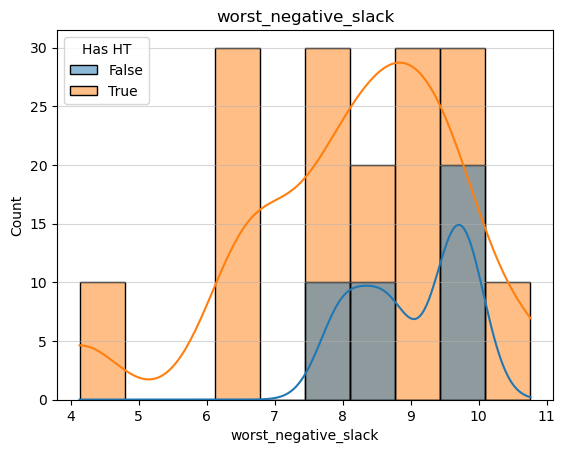

In [86]:
tmp = df.copy()
tmp['Has HT'] = df.apply(lambda row: row['ht_type'] != 'ht-free', axis=1)
ax = sns.histplot(data=tmp, x='worst_negative_slack', hue='Has HT', bins=10, kde=True)
plt.title('worst_negative_slack')
plt.grid(axis='y', alpha=0.5)
plt.show()

# ax = sns.histplot(data=tmp, x='LUT', hue='Has HT', bins=10, kde=True)
# plt.title('LUT')
# plt.grid(axis='y', alpha=0.5)
# plt.show()

# ax = sns.histplot(data=tmp, x='temperature', hue='Has HT', bins=10, kde=True)
# plt.title('temperature')
# plt.grid(axis='y', alpha=0.5)
# plt.show()

# ax = sns.scatterplot(data=tmp, x='worst_negative_slack', y='LUT', hue='Has HT',)
# plt.title('Worst Negative Slack vs LUT')
# plt.grid(axis='both', alpha=0.5)
# plt.show()

### Dimensionality Reduction Analysis

#### PCA

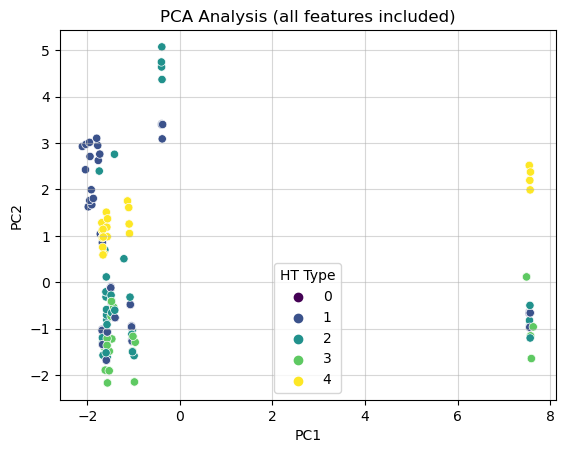

In [87]:
# Split the data into features (X) and target (y)
X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'], axis=1).replace({'benchmark': benchmark_labels})
y = df['ht_type'].replace(ht_labels)
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Perform PCA
pca = PCA(n_components=2)  # You can choose the number of components you want to keep
principal_components = pca.fit_transform(X_std)
# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# Concatenate the principal components with the target variable (if applicable)
pca_df['HT Type'] = y
# Visualize the PCA results using Seaborn
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='HT Type', palette='viridis')
plt.title('PCA Analysis (all features included)')
plt.grid(axis='both', alpha=0.5)
plt.show()

#### UMAP

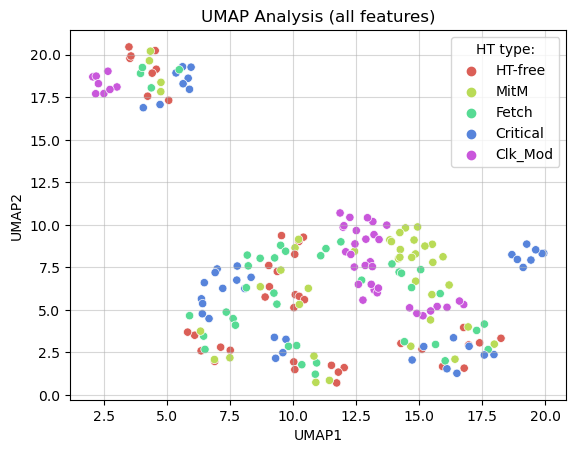

In [88]:
X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'], axis=1).replace({'benchmark': benchmark_labels})
y = df['ht_type'].replace(ht_labels)
# Standardize the features (important for UMAP)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Perform UMAP
umap_model = umap.UMAP(
    n_neighbors=30, # 40
    min_dist=1.0, # 1.0
    n_epochs=200,
    n_components=2,
    random_state=42,
)
umap_result = umap_model.fit_transform(X_std)
# Create a new DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
# Concatenate the UMAP components with the target variable (if applicable)
# umap_df['HT Type'] = y
umap_df['HT Type'] = df['ht_type']
# Visualize the UMAP results using Seaborn
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='HT Type', palette='hls')
plt.title('UMAP Analysis (all features)')
plt.grid(axis='both', alpha=0.5)
# Rename legend labels
httype2name = {
    'ht-free': 'HT-free',
    'mitm': 'MitM',
    'fetch': 'Fetch',
    'critical': 'Critical',
    'clk_mod': 'Clk_Mod',
}
handles, labels = plt.gca().get_legend_handles_labels()
labels = [httype2name[label] for label in labels]
plt.legend(handles, labels, title='HT type:', loc='upper right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig(os.path.join(fig_dir, 'umap_all_features.pdf'), bbox_inches='tight')
plt.show()

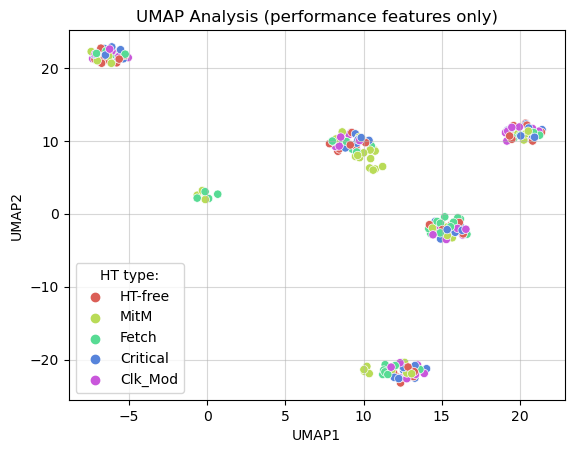

In [89]:
impl_features = [k for k, v in feature_types.items() if v == 'implementation']
X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'] + impl_features, axis=1).replace({'benchmark': benchmark_labels})
y = df['ht_type'].replace(ht_labels)
# Standardize the features (important for UMAP)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Perform UMAP
umap_model = umap.UMAP(
    n_neighbors=30, # 40
    min_dist=1.0, # 1.0
    n_epochs=200,
    n_components=2,
    random_state=42,
)
umap_result = umap_model.fit_transform(X_std)
# Create a new DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
# Concatenate the UMAP components with the target variable (if applicable)
# umap_df['HT Type'] = y
umap_df['HT type:'] = df['ht_type']
# Visualize the UMAP results using Seaborn
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='HT type:', palette='hls')
plt.title('UMAP Analysis (performance features only)')
plt.grid(axis='both', alpha=0.5)
# Rename legend labels
httype2name = {
    'ht-free': 'HT-free',
    'mitm': 'MitM',
    'fetch': 'Fetch',
    'critical': 'Critical',
    'clk_mod': 'Clk_Mod',
}
handles, labels = plt.gca().get_legend_handles_labels()
labels = [httype2name[label] for label in labels]
plt.legend(handles, labels, title='HT type:', loc='lower left') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig(os.path.join(fig_dir, 'umap_perf_features.pdf'), bbox_inches='tight')
plt.show()

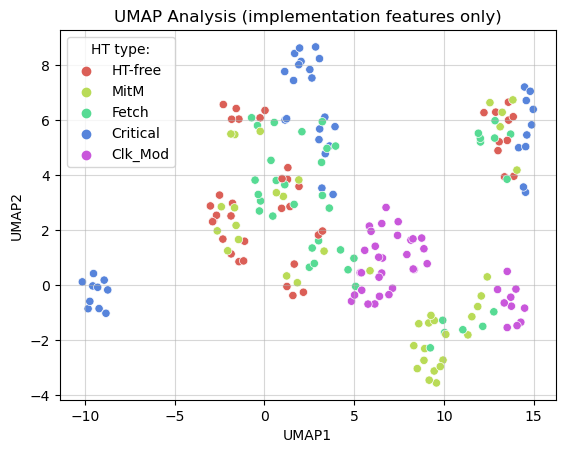

In [90]:
perf_features = [k for k, v in feature_types.items() if v == 'performance']
X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'] + perf_features, axis=1).replace({'benchmark': benchmark_labels})
y = df['ht_type'].replace(ht_labels)
# Standardize the features (important for UMAP)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Perform UMAP
umap_model = umap.UMAP(
    n_neighbors=30, # 40
    min_dist=1.0, # 1.0
    n_epochs=200,
    n_components=2,
    random_state=42,
)
umap_result = umap_model.fit_transform(X_std)
# Create a new DataFrame with the UMAP components
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
# Concatenate the UMAP components with the target variable (if applicable)
# umap_df['HT Type'] = y
umap_df['HT Type'] = df['ht_type']
# Visualize the UMAP results using Seaborn
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='HT Type', palette='hls')
plt.title('UMAP Analysis (implementation features only)')
plt.grid(axis='both', alpha=0.5)
# Rename legend labels
httype2name = {
    'ht-free': 'HT-free',
    'mitm': 'MitM',
    'fetch': 'Fetch',
    'critical': 'Critical',
    'clk_mod': 'Clk_Mod',
}
handles, labels = plt.gca().get_legend_handles_labels()
labels = [httype2name[label] for label in labels]
plt.legend(handles, labels, title='HT type:', loc='upper left') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig(os.path.join(fig_dir, 'umap_impl_features.pdf'), bbox_inches='tight')
plt.show()

#### t-SNE

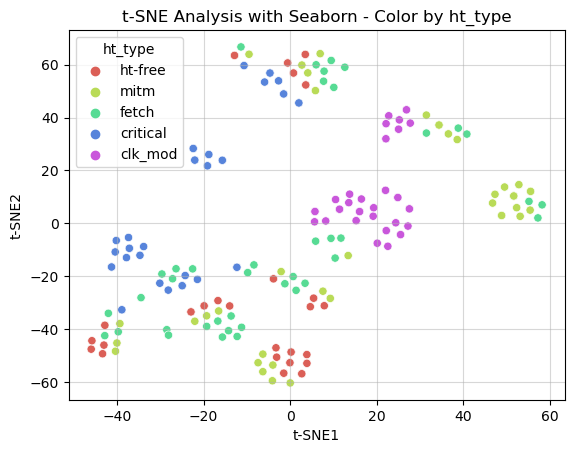

In [91]:
from sklearn.manifold import TSNE

perf_features = [k for k, v in feature_types.items() if v == 'performance']
# X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'], axis=1).replace({'benchmark': benchmark_labels})
X = df.drop(['ht_type', 'ht_type_with_trigger', 'ht_triggered'] + perf_features, axis=1).replace({'benchmark': benchmark_labels})

# Standardize the features (important for UMAP)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Perform t-SNE
tsne_model = TSNE(n_components=2, perplexity=20, random_state=42)  # You can choose the number of components you want to keep
tsne_result = tsne_model.fit_transform(X_std)
# Create a new DataFrame with the t-SNE components
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])
# Concatenate the t-SNE components with the target variable
tsne_df['ht_type'] = df['ht_type']
# Visualize the t-SNE results using Seaborn, coloring by 'ht_type'
# plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='t-SNE1', y='t-SNE2', hue='ht_type', palette='hls', legend='full')
plt.title('t-SNE Analysis with Seaborn - Color by ht_type')
plt.grid(axis='both', alpha=0.5)
plt.show()

## XGBoost Training

In [92]:
def train_xgboost(X_train, X_test, y_train, y_test, scale_input=False):
    # Convert to XGBoost-specific data structures
    if scale_input:
        scaler = StandardScaler()
        dtrain = xgb.DMatrix(scaler.fit_transform(X_train), label=y_train)
        dtest = xgb.DMatrix(scaler.transform(X_test), label=y_test)
    else:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
    # Train the classifier on the training data
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgb_classifier = xgb.train(
        params={
            'objective': 'multi:softprob',
            # 'objective': 'multi:softmax',
            'num_class': len(ht_types),
            'eval_metric': 'mlogloss',
        },
        dtrain=dtrain,
        num_boost_round=20,
        evals=evallist,
        early_stopping_rounds=5,
        verbose_eval=False,
    )
    if scale_input:
        return xgb_classifier, scaler
    else:
        return xgb_classifier

def test_xgboost(xgb_classifier, X_test, y_test, scaler=None):
    if scaler is not None:
        dtest = xgb.DMatrix(scaler.transform(X_test), label=y_test)
    else:
        dtest = xgb.DMatrix(X_test, label=y_test)
    # Make predictions on the test data
    y_pred = xgb_classifier.predict(dtest)
    # Calculate the accuracy of the classifier
    cls_accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
    # print('Classification accuracy:', cls_accuracy)
    det_accuracy = accuracy_score(
        y_test != ht_labels_with_trigger['ht-free'],
        y_pred.argmax(axis=1) != ht_labels_with_trigger['ht-free'],
    )
    # print('Detection accuracy:', det_accuracy)
    cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
    # print(f'Confusion matrix:\n{cm}')
    return cls_accuracy, det_accuracy, cm

def plot_xgboost(xgb_classifier, cm=None, ticklabels=list(ht_types.values()), base_filename=None, show_plots=False):
    # Plot feature importance
    # ax = xgb.plot_importance(xgb_classifier)

    feature_important = xgb_classifier.get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)
    ax = data.nsmallest(40, columns='score').plot(kind='barh') # , figsize=(8, 5)) ## plot top 40 features
    # ax = data.nlargest(40, columns='score').plot(kind='barh') # , figsize=(8, 5)) ## plot top 40 features
    ax.get_legend().remove()
    plt.grid(axis='x', alpha=0.75)
    # Rename y labels
    name2label = {
        'num_cycles': 'Сycles',
        'num_instructions_retired': 'InstrRet',
        'datamem_wait_cycles': 'LSUs',
        'fetch_wait_cycles': 'FetchWait',
        'num_load_instructions': 'Loads',
        'num_store_instructions': 'Stores',
        'num_jump_instructions': 'Jumps',
        'num_conditional_branch_instructions': 'CondBran',
        'num_taken_conditional_branch_instructions': 'TakCBran',
        'num_compressed_instructions': 'ComprIns',
        'mult_wait_cycles': 'MulWait',
        'divd_wait_cycles': 'DivdWait',
        'avg_dynamic_power': 'AvgDynPow',
        'avg_static_power': 'AvgTotPow',
        'benchmark': 'Benchmark',
        'FF': 'FFs',
        'LUT': 'LUTs',
        'worst_negative_slack': 'Timing',
        'temperature': 'Temperature',
    }
    yticklabels = ax.get_yticklabels()
    new_yticklabels = [name2label[label.get_text()] for label in yticklabels]
    ax.set_yticklabels(new_yticklabels)
    plt.xlabel('Feature importance')
    plt.ylabel('Input Features')


    plt.tight_layout()
    if base_filename is not None:
        plt.savefig(os.path.join(fig_dir, base_filename.replace('.pdf', '_importance.pdf')), bbox_inches='tight')
    if show_plots:
        plt.show()
    else:
        plt.close()

    # Confusion Matrix
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # tmp = {v: k for k, v in ht_labels_with_trigger.items()}
    # ax.xaxis.set_ticklabels([tmp[i].replace('triggered', 'T').replace('non-', 'N') for i in range(len(ht_labels_with_trigger))])
    # ax.yaxis.set_ticklabels([tmp[i].replace('triggered', 'T').replace('non-', 'N') for i in range(len(ht_labels_with_trigger))])
    ax.xaxis.set_ticklabels(ticklabels)
    ax.yaxis.set_ticklabels(ticklabels)
    # plt.title(f'Implementation feature left in: {feat}')
    # plt.tight_layout()
    if base_filename is not None:
        plt.savefig(os.path.join(fig_dir, base_filename.replace('.pdf', '_cm.pdf')), bbox_inches='tight')
    if show_plots:
        plt.show()
    else:
        plt.close()

In [93]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from collections import defaultdict

def train_xgboost_with_cv(X, y, num_folds=5, scale_input=False):
    # Initialize KFold cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    # Lists to store results from each fold
    metrics = defaultdict(list)
    train_losses = []
    val_losses = []
    best_xgb_classifier = None
    best_val_acc = -1
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Convert to XGBoost-specific data structures
        if scale_input:
            xgb_classifier, scaler = train_xgboost(X_train, X_val, y_train, y_val, scale_input=True)
            dtrain = xgb.DMatrix(scaler.transform(X_train), label=y_train)
            dval = xgb.DMatrix(scaler.transform(X_val), label=y_val)
        else:
            scaler = None
            xgb_classifier = train_xgboost(X_train, X_val, y_train, y_val)
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)
        # Predict probabilities for the validation set
        y_val_pred = xgb_classifier.predict(dval)
        y_train_pred = xgb_classifier.predict(dtrain)
        # Calculate log loss for training and validation sets
        train_loss = log_loss(y_train, y_train_pred, labels=list(ht_labels.values()))
        val_loss = log_loss(y_val, y_val_pred, labels=list(ht_labels.values()))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        cls_accuracy, det_accuracy, cm = test_xgboost(xgb_classifier, X_test, y_test, scaler=scaler)
        metrics['train_losses'].append(train_loss)
        metrics['val_losses'].append(val_loss)
        metrics['val_cls_accuracies'].append(cls_accuracy)
        metrics['val_det_accuracies'].append(det_accuracy)
        metrics['val_cm'].append(cm)
        if cls_accuracy > best_val_acc:
            best_val_acc = cls_accuracy
            best_xgb_classifier = xgb_classifier
    metrics = {k: np.array(v) for k, v in metrics.items()}
    if scale_input:
        return best_xgb_classifier, metrics, scaler
    else:
        return best_xgb_classifier, metrics

X_train, X_test, y_train, y_test = get_train_test_sets(df)
xgb_classifier, metrics = train_xgboost_with_cv(X_train, y_train, num_folds=5)
cls_accuracy, det_accuracy, cm = test_xgboost(xgb_classifier, X_test, y_test)
metrics['test_cls_accuracy'] = cls_accuracy
metrics['test_det_accuracy'] = det_accuracy
metrics['test_cm'] = cm
print('[CV] Avg. Train loss:', metrics['train_losses'].mean())
print('[CV] Avg. Val loss:', metrics['val_losses'].mean())
print('[CV] Avg. Val Classification Accuracy:', metrics['val_cls_accuracies'].mean())
print('[CV] Avg. Val Detection Accuracy:', metrics['val_det_accuracies'].mean())
print('[CV] Avg. Val Confusion matrix:\n', metrics['val_cm'].mean(axis=0).round(1))
print('Test Confusion matrix:\n', metrics['test_cm'])
print('Test Classification Accuracy:', metrics['test_cls_accuracy'])
print('Test Detection Accuracy:', metrics['test_det_accuracy'])

[CV] Avg. Train loss: 0.04463714605762867
[CV] Avg. Val loss: 0.12287496184837354
[CV] Avg. Val Classification Accuracy: 0.975
[CV] Avg. Val Detection Accuracy: 0.985
[CV] Avg. Val Confusion matrix:
 [[9.4 0.6 0.  0.  0. ]
 [0.  8.8 0.2 0.  0. ]
 [0.  0.2 5.8 0.  0. ]
 [0.  0.  0.  6.  0. ]
 [0.  0.  0.  0.  9. ]]
Test Confusion matrix:
 [[10  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0  9]]
Test Classification Accuracy: 1.0
Test Detection Accuracy: 1.0


Given the 

In [95]:
impl_features = [k for k, v in feature_types.items() if v == 'implementation']
report_table = []
for ht_free_test_perc in [0.2, 0.5]:
    for feat in ['all']: #, None] + impl_features:
        curr_impl_features = impl_features.copy()
        if feat in curr_impl_features:
            curr_impl_features.remove(feat)
        try:
            X_train, X_test, y_train, y_test = get_train_test_sets(
                df,
                test_perc=0.2,
                ht_free_test_perc=ht_free_test_perc,
            )
        except Exception as e:
            print(f'==> Exception occurred: {e}')
            continue
        if feat != 'all':
            X_train = X_train.drop(curr_impl_features, axis=1)
            X_test = X_test.drop(curr_impl_features, axis=1)
        for train_perc in [1.0 - i * 0.1 for i in range(10)]:
            # Sample train_perc from X_train and y_train accordingly
            train_size = int(train_perc * len(X_train))
            X_train_tmp = X_train.sample(train_size, random_state=42)
            y_train_tmp = y_train[X_train_tmp.index]    
            xgb_classifier, metrics = train_xgboost_with_cv(
                X_train_tmp,
                y_train_tmp,
                num_folds=5,
            )
            if feat == 'all':
                feat_id = 'all-features'
            else:
                feat_id = f'with-{feat.replace("_", "-")}' if feat is not None else 'perf-features-only'
            cls_accuracy, det_accuracy, cm = test_xgboost(xgb_classifier, X_test, y_test)
            metrics['test_cls_accuracy'] = cls_accuracy
            metrics['test_det_accuracy'] = det_accuracy
            print(f'Train percentage: {train_perc * 0.8:.0%} | HT-free percent: {ht_free_test_perc:.0%} | Features: {feat_id} | Cls. Accuracy: {cls_accuracy:.1%} | Det. accuracy: {det_accuracy:.1%}')
            metrics['test_cm'] = cm
            # plot_xgboost(xgb_classifier, cm, base_filename=os.path.join(fig_dir, f'xgb_{train_perc * 0.8:.0%}-train_{ht_free_test_perc:.0%}-ht-free_{feat_id}.pdf'))
            # Average CV metrics
            metrics['avg_train_loss'] = metrics['train_losses'].mean()
            metrics['avg_val_loss'] = metrics['val_losses'].mean()
            metrics['avg_val_cls_accuracy'] = metrics['val_cls_accuracies'].mean()
            metrics['avg_val_det_accuracy'] = metrics['val_det_accuracies'].mean()
            metrics['avg_val_cm'] = metrics['val_cm'].mean(axis=0).round(1)
            del metrics['train_losses']
            del metrics['val_losses']
            del metrics['val_cls_accuracies']
            del metrics['val_det_accuracies']
            del metrics['val_cm']
            metrics['input_features'] = feat_id
            metrics['train_perc'] = train_perc * 0.8
            metrics['ht_free_test_perc'] = ht_free_test_perc
            report_table.append(metrics)
report_df = pd.DataFrame(report_table)
report_df.head()

Train percentage: 80% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 100.0% | Det. accuracy: 100.0%
Train percentage: 72% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 100.0% | Det. accuracy: 100.0%
Train percentage: 64% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 100.0% | Det. accuracy: 100.0%
Train percentage: 56% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 87.5% | Det. accuracy: 95.0%
Train percentage: 48% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 85.0% | Det. accuracy: 92.5%
Train percentage: 40% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 85.0% | Det. accuracy: 92.5%
Train percentage: 32% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 80.0% | Det. accuracy: 90.0%
Train percentage: 24% | HT-free percent: 20% | Features: all-features | Cls. Accuracy: 75.0% | Det. accuracy: 90.0%
Train percentage: 16% | HT-free percent: 20% | Features: all-featu

,test_cls_accuracy,test_det_accuracy,test_cm,avg_train_loss,avg_val_loss,avg_val_cls_accuracy,avg_val_det_accuracy,avg_val_cm,input_features,train_perc,ht_free_test_perc
0,1.000,1.000,"[[8, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 0, 6, ...",0.043578,0.096535,0.980,1.00,"[[8.0, 0.0, 0.0, 0.0, 0.0], [0.0, 9.2, 0.8, 0....",all-features,0.80,0.2
1,1.000,1.000,"[[8, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 0, 6, ...",0.047861,0.103943,0.980,1.00,"[[8.0, 0.0, 0.0, 0.0, 0.0], [0.0, 9.2, 0.8, 0....",all-features,0.72,0.2
2,1.000,1.000,"[[8, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 0, 6, ...",0.054410,0.197709,0.935,0.98,"[[7.8, 0.2, 0.0, 0.0, 0.0], [0.0, 9.0, 1.0, 0....",all-features,0.64,0.2
3,0.875,0.950,"[[8, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 1, 5, ...",0.063433,0.225983,0.840,0.92,"[[7.6, 0.4, 0.0, 0.0, 0.0], [0.0, 8.4, 1.6, 0....",all-features,0.56,0.2
4,0.850,0.925,"[[8, 0, 0, 0, 0], [0, 9, 1, 0, 0], [0, 1, 5, 0...",0.076794,0.357717,0.785,0.90,"[[7.0, 0.8, 0.2, 0.0, 0.0], [0.0, 7.2, 2.8, 0....",all-features,0.48,0.2


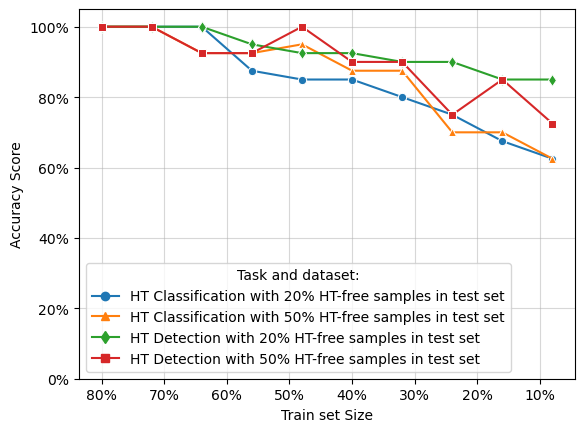

In [99]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

tmp = report_df
tmp = report_df[report_df['input_features'] == 'all-features']
# tmp = tmp[tmp['ht_free_test_perc'] == 0.5]
# Plot how the classification accuracy changes with the percentage of training data
# Highlight the points and their respective values in percentage

def get_task(row, task_name='Classification'):
    ht_free_test_perc = row['ht_free_test_perc']
    task = f"HT {task_name} with {ht_free_test_perc:.0%} HT-free samples in test set"
    row['task'] = task
    tmp = 'cls' if task_name == 'Classification' else 'det'
    row['accuracy'] = row[f'test_{tmp}_accuracy']
    return row
tmp = pd.concat([
    tmp.apply(partial(get_task, task_name='Classification'), axis=1),
    tmp.apply(partial(get_task, task_name='Detection'), axis=1),
], axis=0, ignore_index=True)[['train_perc', 'accuracy', 'task']].drop_duplicates()


ax = sns.lineplot(data=tmp, x='train_perc', y='accuracy', hue='task', palette='tab10', markers=True)
# # Set different markers
ax.lines[0].set_marker('o')
ax.lines[1].set_marker('^')
ax.lines[2].set_marker('d')
ax.lines[3].set_marker('s')
# Change legend markers
handles, labels = ax.get_legend_handles_labels()
handles[0].set_marker('o')
handles[1].set_marker('^')
handles[2].set_marker('d')
handles[3].set_marker('s')
# Change legend title and position
ax.legend(handles, labels, title='Task and dataset:', loc='lower left')

# Change axis labels
plt.ylabel('Accuracy Score')
plt.xlabel('Train set Size')
plt.grid(axis='both', alpha=0.5)
# Reverse x-axis
plt.gca().invert_xaxis()
# Set both axis to percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylim(0, 1.05)
plt.savefig(os.path.join(fig_dir, 'xgboost_cls_accuracy_train_size.pdf'), bbox_inches='tight')
plt.show()


Change the percentage of HT-free data to be used in test set and whether to remove implementation features: 

In [58]:
impl_features = [k for k, v in feature_types.items() if v == 'implementation']
report_table = []
for test_perc in [0.2]: # , 0.4, 0.6]:
    for ht_free_test_perc in [0.2, 0.5]:
        for feat in ['all', None] + impl_features:
            curr_impl_features = impl_features.copy()
            if feat in curr_impl_features:
                curr_impl_features.remove(feat)
            try:
                X_train, X_test, y_train, y_test = get_train_test_sets(
                    df,
                    test_perc=test_perc,
                    ht_free_test_perc=ht_free_test_perc,
                )
                if feat != 'all':
                    X_train = X_train.drop(curr_impl_features, axis=1)
                    X_test = X_test.drop(curr_impl_features, axis=1)
                # xgb_classifier, metrics = train_xgboost_with_cv(X_train, y_train, num_folds=5)
                xgb_classifier, metrics = train_xgboost_with_cv(
                    pd.concat([X_train, X_test], axis=0),
                    pd.concat([y_train, y_test], axis=0),
                    num_folds=5,
                )
            except Exception as e:
                print(f'==> Exception occurred: {e}')
                continue
            if feat == 'all':
                feat_id = 'all-features'
            else:
                feat_id = f'with-{feat.replace("_", "-")}' if feat is not None else 'perf-features-only'
            print(f'Test percentage: {test_perc:.0%} | HT-free percent: {ht_free_test_perc:.0%} | Features: {feat_id}')
            cls_accuracy, det_accuracy, cm = test_xgboost(xgb_classifier, X_test, y_test)
            metrics['test_cls_accuracy'] = cls_accuracy
            metrics['test_det_accuracy'] = det_accuracy
            metrics['test_cm'] = cm
            # plot_xgboost(xgb_classifier, cm, base_filename=os.path.join(fig_dir, f'xgb_{test_perc:.0%}-test_{ht_free_test_perc:.0%}-ht-free_{feat_id}.pdf'))
            # Average CV metrics
            metrics['avg_train_loss'] = metrics['train_losses'].mean()
            metrics['avg_val_loss'] = metrics['val_losses'].mean()
            metrics['avg_val_cls_accuracy'] = metrics['val_cls_accuracies'].mean()
            metrics['avg_val_det_accuracy'] = metrics['val_det_accuracies'].mean()
            metrics['avg_val_cm'] = metrics['val_cm'].mean(axis=0).round(1)
            del metrics['train_losses']
            del metrics['val_losses']
            del metrics['val_cls_accuracies']
            del metrics['val_det_accuracies']
            del metrics['val_cm']
            metrics['input_features'] = feat_id
            metrics['test_perc'] = test_perc
            metrics['ht_free_test_perc'] = ht_free_test_perc
            report_table.append(metrics)
report_df = pd.DataFrame(report_table)
report_df.head()

Test percentage: 20% | HT-free percent: 20% | Features: all-features
Test percentage: 20% | HT-free percent: 20% | Features: perf-features-only
Test percentage: 20% | HT-free percent: 20% | Features: with-avg-dynamic-power
Test percentage: 20% | HT-free percent: 20% | Features: with-avg-static-power
Test percentage: 20% | HT-free percent: 20% | Features: with-FF
Test percentage: 20% | HT-free percent: 20% | Features: with-LUT
Test percentage: 20% | HT-free percent: 20% | Features: with-worst-negative-slack
Test percentage: 20% | HT-free percent: 20% | Features: with-temperature
Test percentage: 20% | HT-free percent: 50% | Features: all-features
Test percentage: 20% | HT-free percent: 50% | Features: perf-features-only
Test percentage: 20% | HT-free percent: 50% | Features: with-avg-dynamic-power
Test percentage: 20% | HT-free percent: 50% | Features: with-avg-static-power
Test percentage: 20% | HT-free percent: 50% | Features: with-FF
Test percentage: 20% | HT-free percent: 50% | Feat

,test_cls_accuracy,test_det_accuracy,test_cm,avg_train_loss,avg_val_loss,avg_val_cls_accuracy,avg_val_det_accuracy,avg_val_cm,input_features,test_perc,ht_free_test_perc
0,1.000,1.00,"[[8, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 0, 6, ...",0.035330,0.076295,1.000,1.000,"[[8.0, 0.0, 0.0, 0.0, 0.0], [0.0, 10.0, 0.0, 0...",all-features,0.2,0.2
1,0.425,0.45,"[[8, 0, 0, 0, 0], [6, 4, 0, 0, 0], [4, 0, 2, 0...",1.254664,1.416271,0.370,0.590,"[[3.8, 0.0, 0.0, 1.8, 2.4], [3.0, 4.0, 0.0, 1....",perf-features-only,0.2,0.2
2,0.650,0.70,"[[7, 0, 0, 1, 0], [5, 4, 0, 1, 0], [3, 0, 2, 1...",0.806482,0.981318,0.605,0.740,"[[5.2, 0.0, 0.0, 2.8, 0.0], [2.6, 4.0, 0.0, 3....",with-avg-dynamic-power,0.2,0.2
3,0.650,0.65,"[[8, 0, 0, 0, 0], [6, 4, 0, 0, 0], [4, 0, 2, 0...",0.774497,0.935107,0.615,0.720,"[[5.6, 0.2, 0.0, 2.2, 0.0], [3.2, 4.0, 0.0, 2....",with-avg-static-power,0.2,0.2
4,0.475,0.70,"[[3, 0, 1, 0, 4], [4, 4, 1, 1, 0], [1, 0, 3, 1...",0.949277,1.243502,0.455,0.615,"[[3.0, 0.0, 0.2, 1.0, 3.8], [4.4, 4.0, 0.2, 1....",with-FF,0.2,0.2


C:\Users\ste\AppData\Local\Temp\ipykernel_24296\3836683885.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


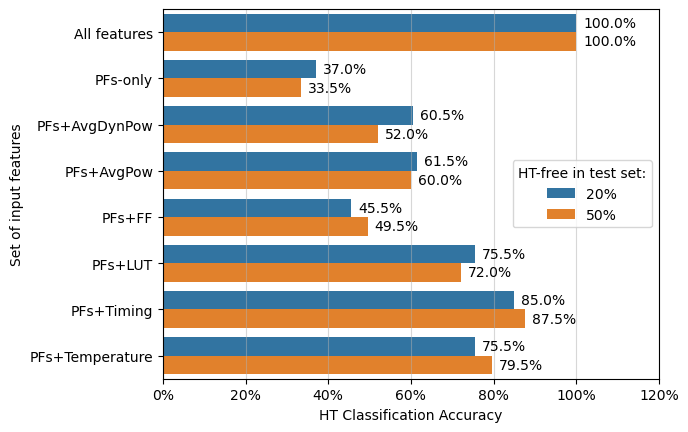

In [65]:
ax = sns.barplot(data=report_df[report_df['test_perc'] == 0.2], x='avg_val_cls_accuracy', y='input_features', hue='ht_free_test_perc')
# Change legend title
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['ht_free_test_perc'].unique()], title='HT-free in test set:', loc='center right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
# Change axis labels
plt.xlabel('HT Classification Accuracy')
plt.ylabel('Set of input features')
# Change yaxis ticks to labels
name2label = {
    'all-features': 'All features',
    'perf-features-only': 'PFs-only',
    'with-avg-static-power': 'PFs+AvgPow',
    'with-avg-dynamic-power': 'PFs+AvgDynPow',
    'with-FF': 'PFs+FF',
    'with-LUT': 'PFs+LUT',
    'with-worst-negative-slack': 'PFs+Timing',
    'with-temperature': 'PFs+Temperature',
}
yticklabels = ax.get_yticklabels()
new_yticklabels = [name2label[label.get_text()] for label in yticklabels]
ax.set_yticklabels(new_yticklabels)
# Change xticks to percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
# Show bar values on top of the bars in percentage format
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlim(0, 1.2)
plt.grid(axis='x', alpha=0.5)
plt.savefig(os.path.join(fig_dir, 'xgboost_cls_accuracy.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'xgboost_cls_accuracy.png'), bbox_inches='tight')
plt.show()

C:\Users\ste\AppData\Local\Temp\ipykernel_24296\1568336301.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


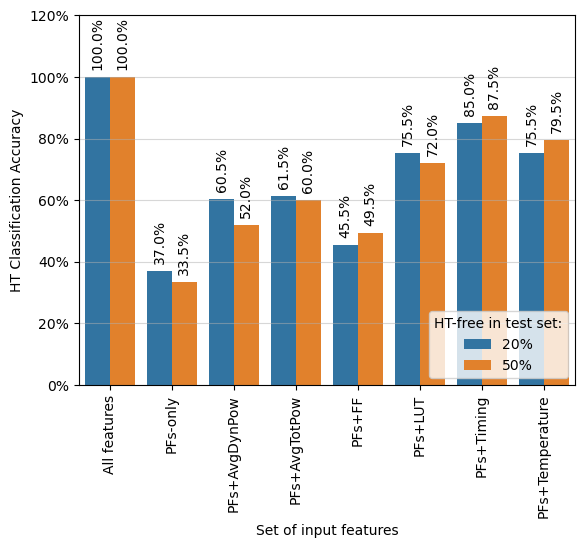

avg_val_cls_accuracy,avg_val_det_accuracy,input_features,ht_free_test_perc
1.0,1.0,All features,0.2
0.37,0.59,PFs-only,0.2
0.605,0.74,PFs+AvgDynPow,0.2
0.615,0.72,PFs+AvgTotPow,0.2
0.455,0.615,PFs+FF,0.2
0.755,0.88,PFs+LUT,0.2
0.85,0.85,PFs+Timing,0.2
0.755,0.76,PFs+Temperature,0.2
1.0,1.0,All features,0.5
0.335,0.535,PFs-only,0.5
0.52,0.63,PFs+AvgDynPow,0.5
0.6,0.705,PFs+AvgTotPow,0.5
0.495,0.6,PFs+FF,0.5
0.72,0.815,PFs+LUT,0.5
0.875,0.875,PFs+Timing,0.5
0.795,0.8,PFs+Temperature,0.5



In [76]:
ax = sns.barplot(data=report_df[report_df['test_perc'] == 0.2], y='avg_val_cls_accuracy', x='input_features', hue='ht_free_test_perc')
# Change legend title
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['ht_free_test_perc'].unique()], title='HT-free in test set:', loc='lower right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
# Change axis labels
plt.xlabel('Set of input features')
plt.ylabel('HT Classification Accuracy')
# Change yaxis ticks to percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
# Show bar values on top of the bars in percentage format
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', rotation=90)
plt.ylim(0, 1.2)
plt.grid(axis='y', alpha=0.5)
name2label = {
    'all-features': 'All features',
    'perf-features-only': 'PFs-only',
    'with-avg-static-power': 'PFs+AvgTotPow',
    'with-avg-dynamic-power': 'PFs+AvgDynPow',
    'with-FF': 'PFs+FF',
    'with-LUT': 'PFs+LUT',
    'with-worst-negative-slack': 'PFs+Timing',
    'with-temperature': 'PFs+Temperature',
}
xticklabels = ax.get_xticklabels()
new_xticklabels = [name2label[label.get_text()] for label in xticklabels]
ax.set_xticklabels(new_xticklabels, rotation=90)
plt.savefig(os.path.join(fig_dir, 'xgboost_cls_accuracy.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'xgboost_cls_accuracy.png'), bbox_inches='tight')
plt.show()
print(report_df[report_df['test_perc'] == 0.2][['avg_val_cls_accuracy', 'avg_val_det_accuracy', 'input_features', 'ht_free_test_perc']].round(4).replace({'input_features': name2label}).to_csv(index=False))

C:\Users\ste\AppData\Local\Temp\ipykernel_24296\3190818014.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


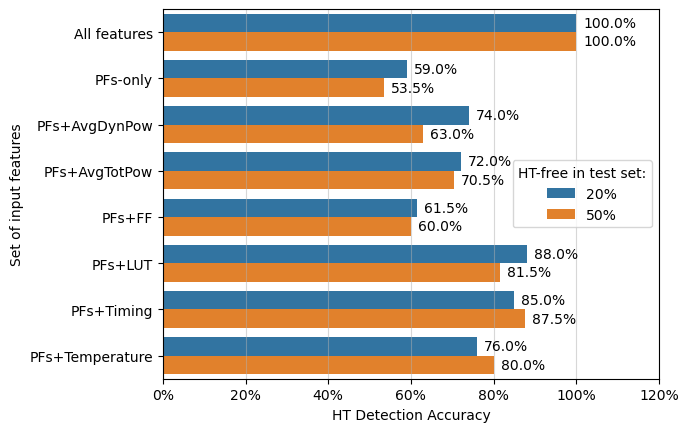

In [77]:
ax = sns.barplot(data=report_df[report_df['test_perc'] == 0.2], x='avg_val_det_accuracy', y='input_features', hue='ht_free_test_perc')
# Change legend title
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['ht_free_test_perc'].unique()], title='HT-free in test set:', loc='center right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
# Change axis labels
plt.xlabel('HT Detection Accuracy')
plt.ylabel('Set of input features')
# Change yaxis ticks to labels
name2label = {
    'all-features': 'All features',
    'perf-features-only': 'PFs-only',
    'with-avg-static-power': 'PFs+AvgTotPow',
    'with-avg-dynamic-power': 'PFs+AvgDynPow',
    'with-FF': 'PFs+FF',
    'with-LUT': 'PFs+LUT',
    'with-worst-negative-slack': 'PFs+Timing',
    'with-temperature': 'PFs+Temperature',
}
yticklabels = ax.get_yticklabels()
new_yticklabels = [name2label[label.get_text()] for label in yticklabels]
ax.set_yticklabels(new_yticklabels)
# Change xaxis ticks to percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
# Show bar values on top of the bars in percentage format
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlim(0, 1.2)
plt.grid(axis='x', alpha=0.5)
plt.savefig(os.path.join(fig_dir, 'xgboost_det_accuracy.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'xgboost_det_accuracy.png'), bbox_inches='tight')
plt.show()

C:\Users\ste\AppData\Local\Temp\ipykernel_24296\3610011950.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


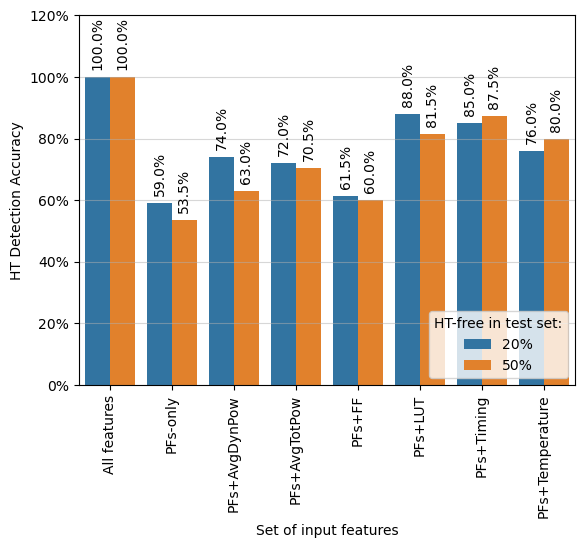

In [78]:
ax = sns.barplot(data=report_df[report_df['test_perc'] == 0.2], y='avg_val_det_accuracy', x='input_features', hue='ht_free_test_perc')
# Change legend title
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['ht_free_test_perc'].unique()], title='HT-free in test set:', loc='lower right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
# Change axis labels
plt.xlabel('Set of input features')
plt.ylabel('HT Detection Accuracy')
# Change yaxis ticks to percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
# Show bar values on top of the bars in percentage format
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', rotation=90)
plt.ylim(0, 1.2)
plt.grid(axis='y', alpha=0.5)
name2label = {
    'all-features': 'All features',
    'perf-features-only': 'PFs-only',
    'with-avg-static-power': 'PFs+AvgTotPow',
    'with-avg-dynamic-power': 'PFs+AvgDynPow',
    'with-FF': 'PFs+FF',
    'with-LUT': 'PFs+LUT',
    'with-worst-negative-slack': 'PFs+Timing',
    'with-temperature': 'PFs+Temperature',
}
xticklabels = ax.get_xticklabels()
new_xticklabels = [name2label[label.get_text()] for label in xticklabels]
ax.set_xticklabels(new_xticklabels, rotation=90)
plt.savefig(os.path.join(fig_dir, 'xgboost_det_accuracy.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'xgboost_det_accuracy.png'), bbox_inches='tight')
plt.show()

C:\Users\ste\AppData\Local\Temp\ipykernel_21168\804708466.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


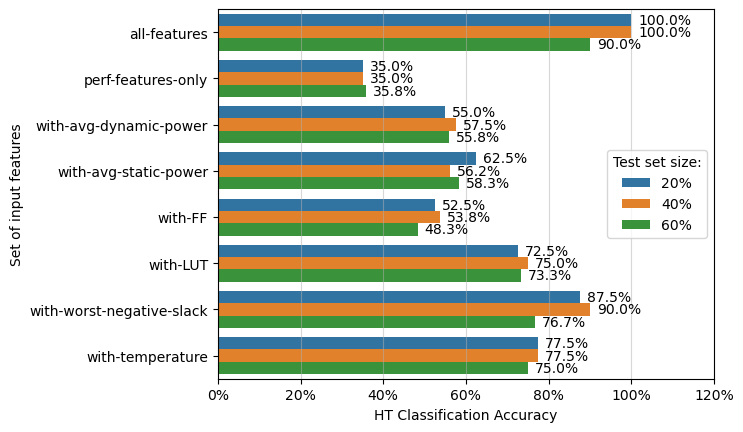

In [286]:
ax = sns.barplot(data=report_df[report_df['ht_free_test_perc'] == 0.25], x='test_cls_accuracy', y='input_features', hue='test_perc')
# Change legend title
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['test_perc'].unique()], title='Test set size:', loc='center right') #, bbox_to_anchor=(0.5, -0.2), ncol=3)
# Change axis labels
plt.xlabel('HT Classification Accuracy')
plt.ylabel('Set of input features')
# Change xaxis ticks to percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
# Show bar values on top of the bars in percentage format
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlim(0, 1.2)
plt.grid(axis='x', alpha=0.5)
plt.show()

C:\Users\ste\AppData\Local\Temp\ipykernel_21168\3482960884.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


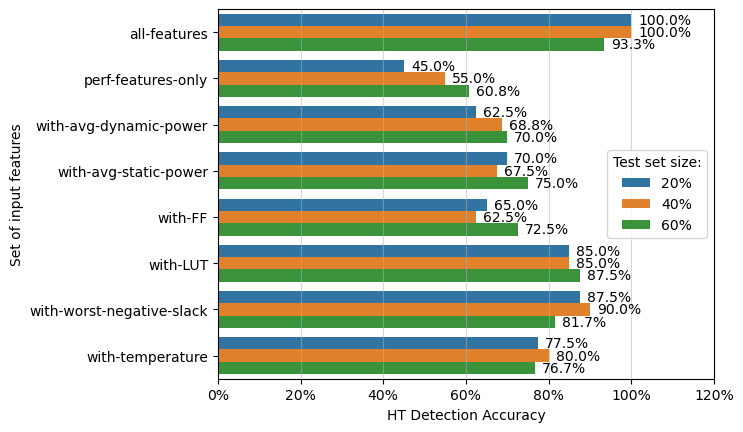

In [287]:
ax = sns.barplot(data=report_df[report_df['ht_free_test_perc'] == 0.25], x='test_det_accuracy', y='input_features', hue='test_perc')
# Change legend elements to percentages and titleok
ax.legend(ax.legend_.legendHandles, ['{:,.0%}'.format(x) for x in report_df['test_perc'].unique()], title='Test set size:', loc='center right')
# Change axis labels
plt.xlabel('HT Detection Accuracy')
plt.ylabel('Set of input features')
# Change xaxis ticks to percentages
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
for p in ax.patches:
    ax.annotate('{:,.1%}'.format(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlim(0, 1.2)
plt.grid(axis='x', alpha=0.5)
plt.show()

Accuracy: 0.75


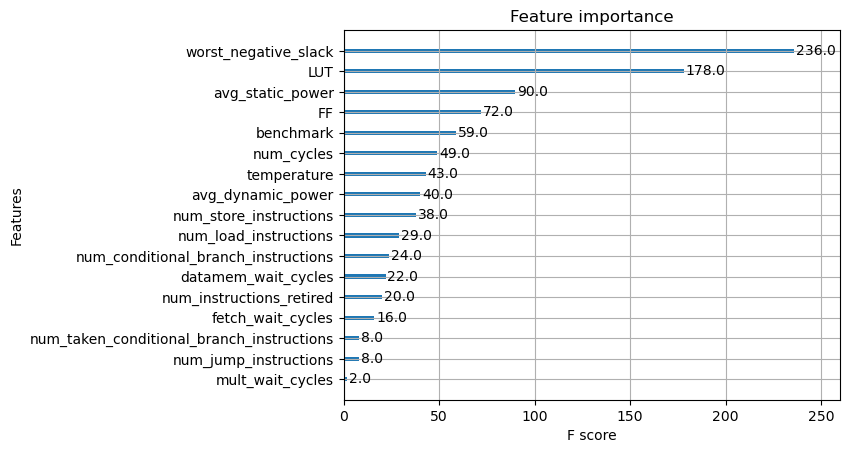

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Classification accuracy: 0.75
Detection accuracy: 1.0
Confusion matrix:
[[20  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]]


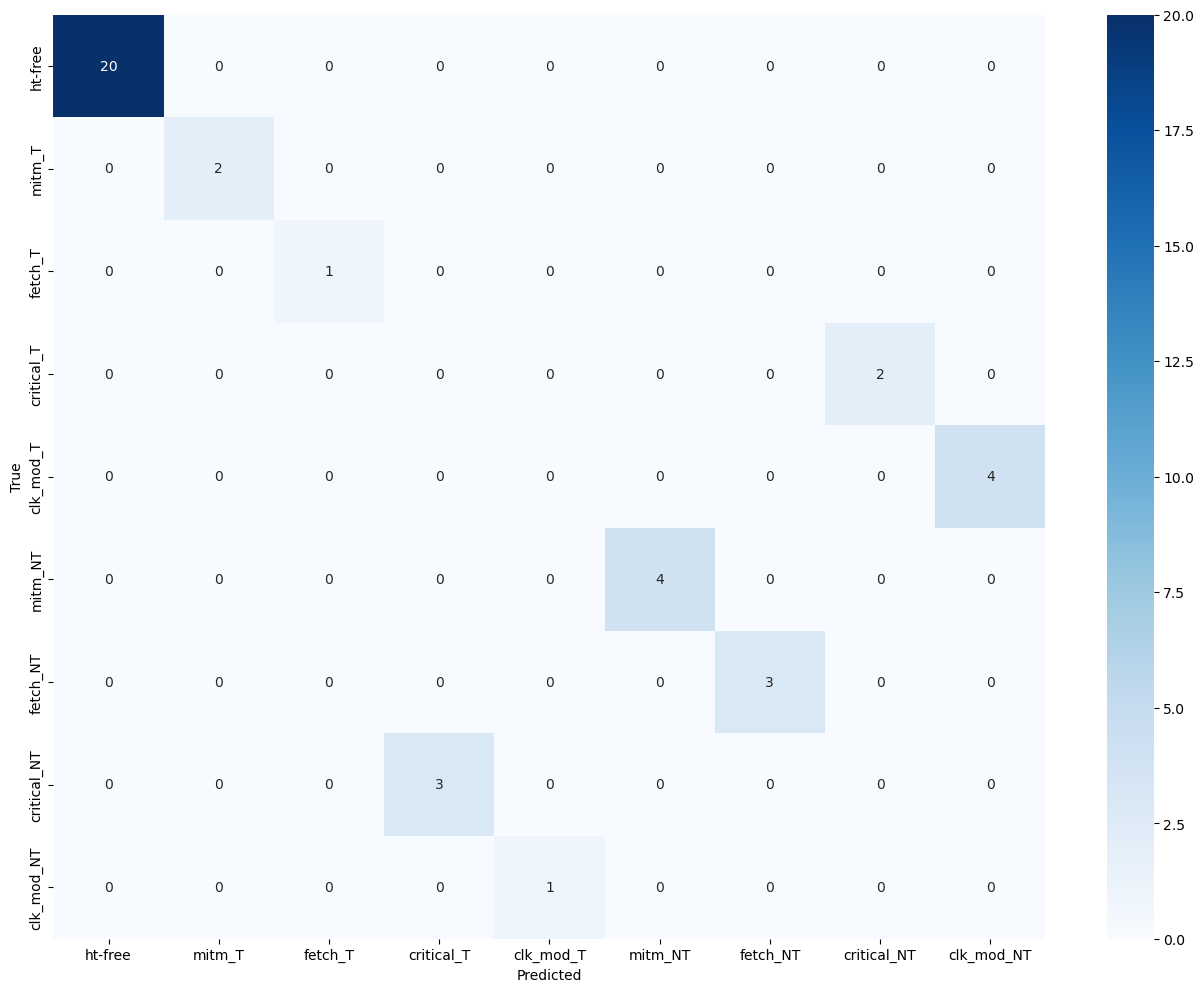

In [204]:
# # Split the data into features (X) and target (y)
# X = df.drop(['ht_type', 'ht_triggered'], axis=1)
# X['benchmark'] = X['benchmark'].astype('category').cat.codes
# y = df['ht_type'].astype('category').cat.codes
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

X_train, X_test, y_train, y_test = get_train_test_sets(df, test_perc=0.2, ht_free_test_perc=0.5, column_label='ht_type_with_trigger')
# Convert to XGBoost-specific data structures
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# Train the classifier on the training data
evallist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_classifier = xgb.train(
    params={
        'objective': 'multi:softprob',
        # 'objective': 'multi:softmax',
        'num_class': len(ht_labels_with_trigger),
        'eval_metric': 'mlogloss',
        # 'device': 'cpu',
    },
    dtrain=dtrain,
    num_boost_round=20,
    evals=evallist,
    early_stopping_rounds=5,
    verbose_eval=False,
)
# Make predictions on the test data
y_pred = xgb_classifier.predict(dtest)
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Accuracy:", accuracy)
ax = xgb.plot_importance(xgb_classifier)
ax.savefig=os.path.join(fig_dir, 'xgb_importance.pdf')
plt.show()

_, _, cm = test_xgboost(xgb_classifier, X_test, y_test)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
tmp = {v: k for k, v in ht_labels_with_trigger.items()}
ax.xaxis.set_ticklabels([tmp[i].replace('triggered', 'T').replace('non-', 'N') for i in range(len(ht_labels_with_trigger))])
ax.yaxis.set_ticklabels([tmp[i].replace('triggered', 'T').replace('non-', 'N') for i in range(len(ht_labels_with_trigger))])
# plt.title(f'Implementation feature left in: {feat}')
# plt.tight_layout()
plt.show()

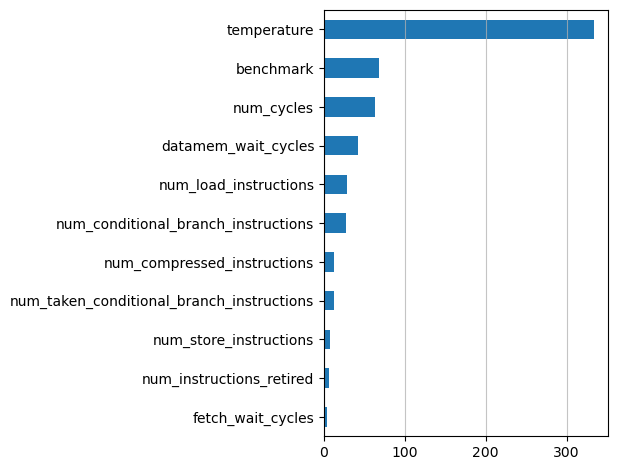

ValueError: feature_names mismatch: ['benchmark', 'num_cycles', 'num_instructions_retired', 'datamem_wait_cycles', 'fetch_wait_cycles', 'num_load_instructions', 'num_store_instructions', 'num_jump_instructions', 'num_conditional_branch_instructions', 'num_taken_conditional_branch_instructions', 'num_compressed_instructions', 'mult_wait_cycles', 'divd_wait_cycles', 'temperature'] ['benchmark', 'avg_dynamic_power', 'avg_static_power', 'FF', 'LUT', 'worst_negative_slack', 'num_cycles', 'num_instructions_retired', 'datamem_wait_cycles', 'fetch_wait_cycles', 'num_load_instructions', 'num_store_instructions', 'num_jump_instructions', 'num_conditional_branch_instructions', 'num_taken_conditional_branch_instructions', 'num_compressed_instructions', 'mult_wait_cycles', 'divd_wait_cycles', 'temperature']
training data did not have the following fields: avg_static_power, LUT, FF, avg_dynamic_power, worst_negative_slack

In [304]:
# Plot feature importance
feature_important = xgb_classifier.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)
ax = data.nsmallest(40, columns='score').plot(kind='barh') # , figsize=(8, 5)) ## plot top 40 features
# ax = data.nlargest(40, columns='score').plot(kind='barh') # , figsize=(8, 5)) ## plot top 40 features
ax.get_legend().remove()
# plt.title(f'Implementation feature left in: {feat}')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.show()

class_probabilities = xgb_classifier.predict(xgb.DMatrix(X))
# Plot histograms for class probabilities
for i, class_label in enumerate(ht_types.values()):
    # plt.hist(class_probabilities[:, i], bins=10, alpha=0.5, label=f'Class {class_label}')
    sns.kdeplot(class_probabilities[:, i], fill=False, alpha=0.3, label=f'Predicted {class_label}')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Predicted Class Probabilities')
plt.show()

cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('-' * 80)
print(cm)
print('-' * 80)
# Plot confusion matrix
# plt.figure(figsize=(3.5, 3))
# ax = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues')
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
ax.xaxis.set_ticklabels(ht_types.values())
ax.yaxis.set_ticklabels(ht_types.values())
# plt.title(f'Implementation feature left in: {feat}')
plt.tight_layout()
plt.show()

Analyze the performance when the input features only consist of the performance counters and possibly one implementation feature only:

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'num_compressed_instructions', 'num_jump_instructions', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.175
Detection accuracy: 0.5
Confusion matrix:
[[ 0  0  0  9 11]
 [ 0  2  0  0  4]
 [ 0  0  1  0  3]
 [ 0  0  0  2  3]
 [ 0  0  0  3  2]]


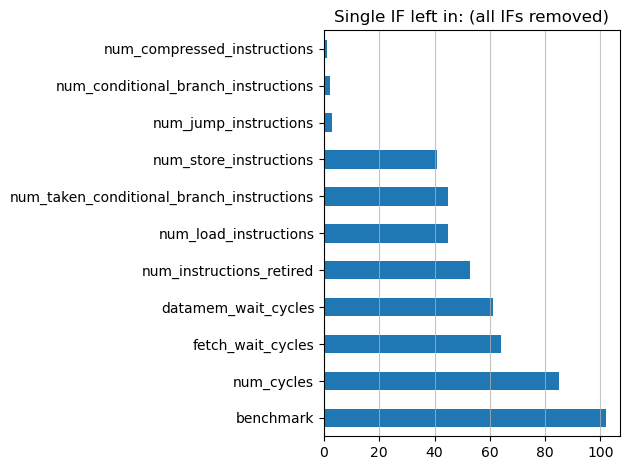

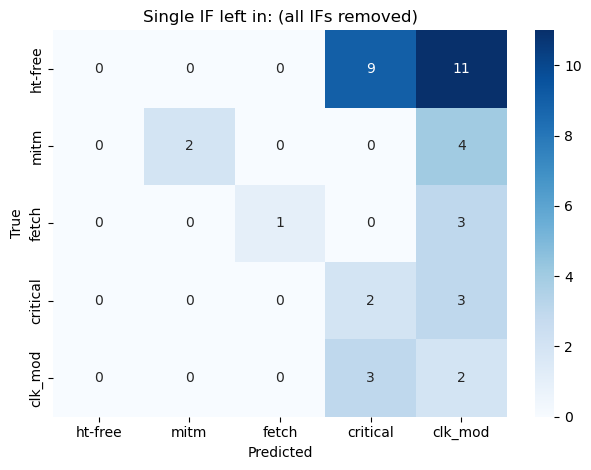

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'num_compressed_instructions', 'num_jump_instructions', 'mult_wait_cycles', 'avg_dynamic_power', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.4
Detection accuracy: 0.575
Confusion matrix:
[[ 4  0  2 14  0]
 [ 0  2  0  4  0]
 [ 0  0  1  3  0]
 [ 1  0  0  4  0]
 [ 0  0  0  0  5]]


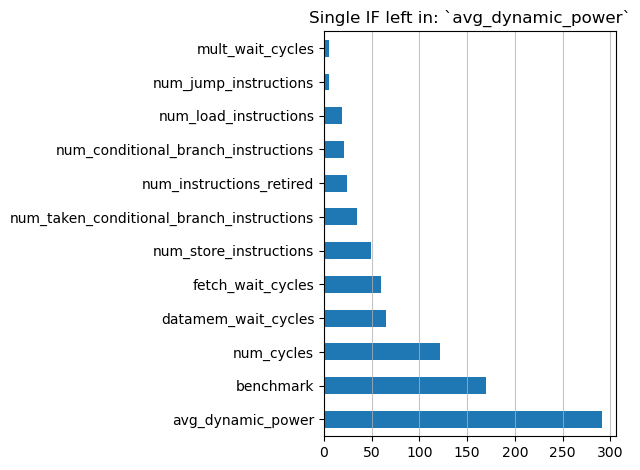

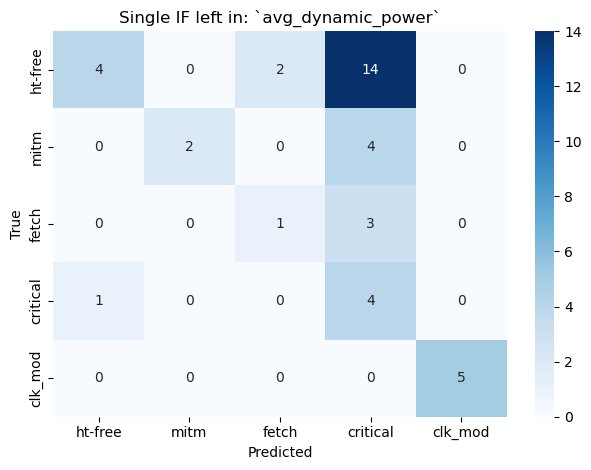

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'avg_static_power', 'num_compressed_instructions', 'num_jump_instructions', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.325
Detection accuracy: 0.5
Confusion matrix:
[[ 0  3  0 17  0]
 [ 0  2  0  4  0]
 [ 0  0  1  3  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  5]]


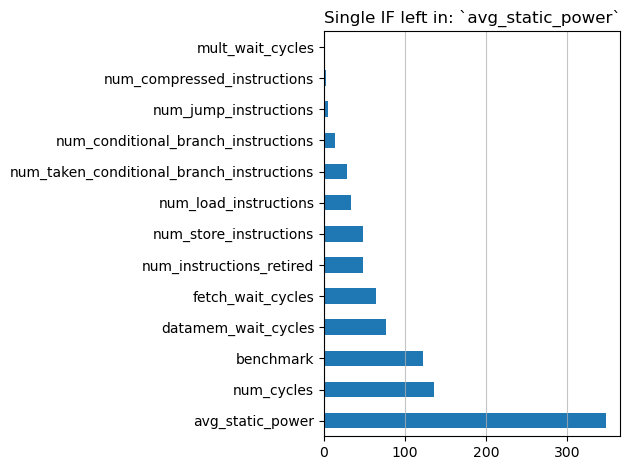

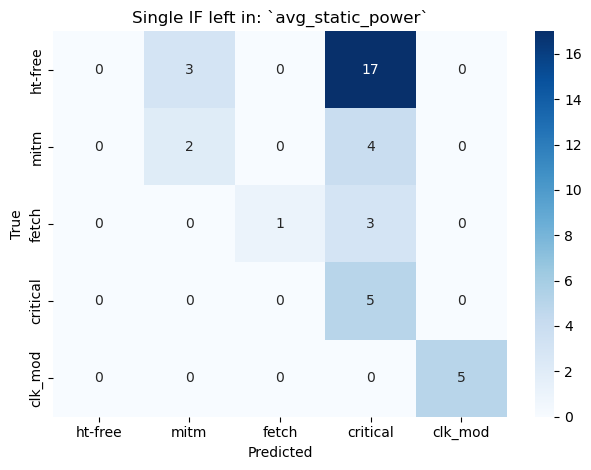

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'num_compressed_instructions', 'num_jump_instructions', 'FF', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.3
Detection accuracy: 0.475
Confusion matrix:
[[4 0 7 3 6]
 [3 2 0 1 0]
 [1 0 1 1 1]
 [1 0 2 0 2]
 [0 0 0 0 5]]


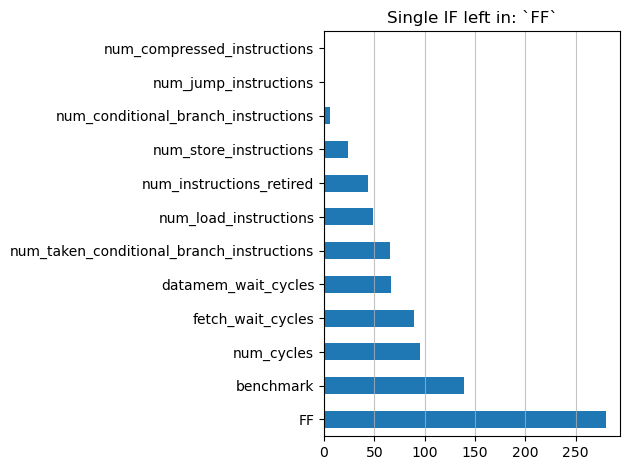

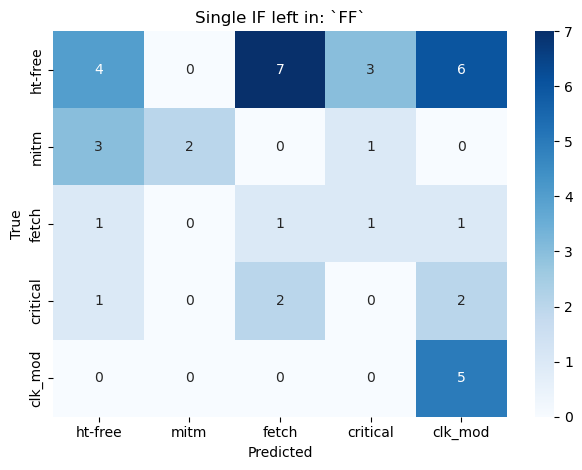

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'num_compressed_instructions', 'num_jump_instructions', 'LUT', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.575
Detection accuracy: 0.725
Confusion matrix:
[[ 9  0  0  0 11]
 [ 0  3  3  0  0]
 [ 0  3  1  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  5]]


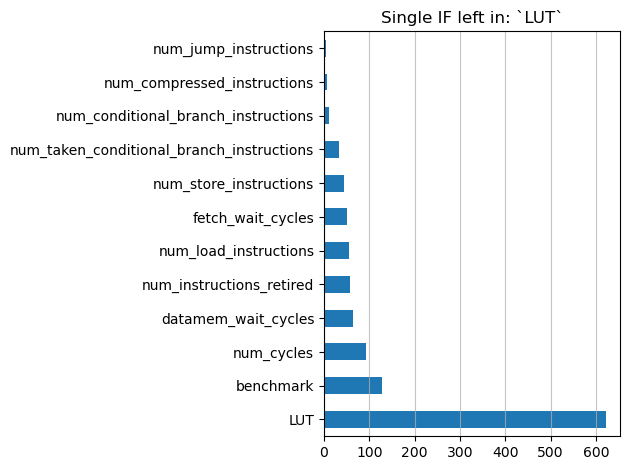

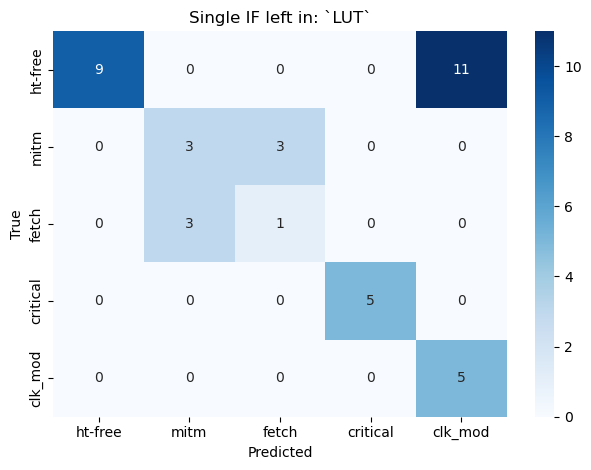

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'fetch_wait_cycles', 'num_cycles', 'num_load_instructions', 'num_compressed_instructions', 'num_jump_instructions', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'worst_negative_slack', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.675
Detection accuracy: 0.675
Confusion matrix:
[[11  9  0  0  0]
 [ 4  2  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  5]]


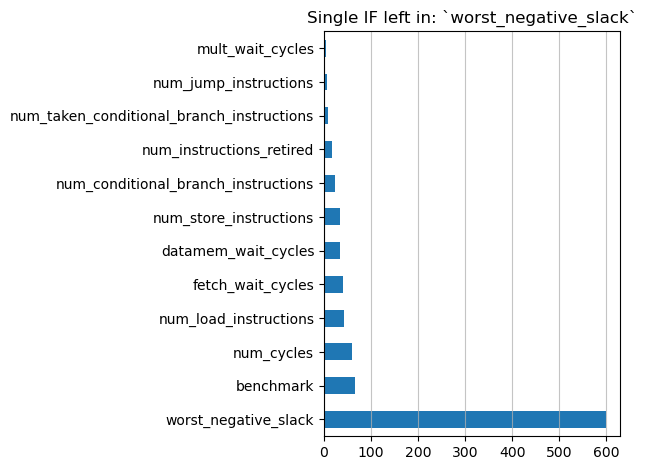

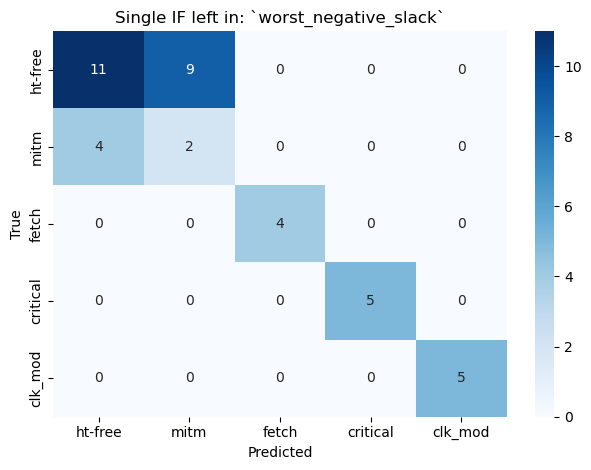

--------------------------------------------------------------------------------
Input features: {'datamem_wait_cycles', 'temperature', 'num_cycles', 'num_load_instructions', 'fetch_wait_cycles', 'num_compressed_instructions', 'num_jump_instructions', 'mult_wait_cycles', 'num_instructions_retired', 'num_conditional_branch_instructions', 'divd_wait_cycles', 'num_store_instructions', 'num_taken_conditional_branch_instructions', 'benchmark'}
Classification accuracy: 0.675
Detection accuracy: 0.675
Confusion matrix:
[[14  0  6  0  0]
 [ 4  2  0  0  0]
 [ 3  0  1  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  5]]


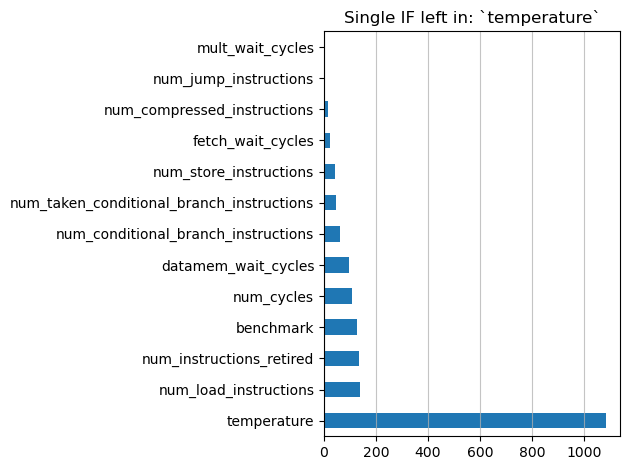

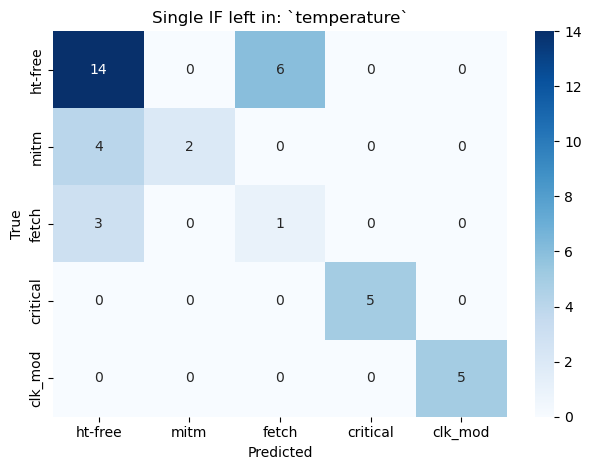

In [122]:
impl_features = [k for k, v in feature_types.items() if v == 'implementation']
for feat in [None] + impl_features:
    print('-' * 80)
    curr_impl_features = impl_features.copy()
    if feat in curr_impl_features:
        curr_impl_features.remove(feat)
    print(f'Input features: {set(X_train.columns) - set(curr_impl_features)}')
    # Drop implementation features
    X_train_tmp = X_train.drop(curr_impl_features, axis=1)
    X_val_tmp = X_val.drop(curr_impl_features, axis=1)

    # # Split the data into features (X) and target (y)
    # X = df.drop(['ht_type', 'ht_triggered'] + curr_impl_features, axis=1)
    # X['benchmark'] = X['benchmark'].astype('category').cat.codes
    # print(list(X.columns))
    # y = df['ht_type'].astype('category').cat.codes
    # # y = df['ht_type'].apply(lambda x: 0 if x == 'free' else 1) #.to_numpy()
    # # Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(X_train_tmp, label=y_train)
    dtest = xgb.DMatrix(X_val_tmp, label=y_val)
    # Train the classifier on the training data
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgb_classifier = xgb.train(
        params={
            # 'objective': 'binary:hinge',
            'objective': 'multi:softmax',
            'num_class': len(ht_types),
            'eval_metric': 'mlogloss',
            'validate_parameters': True,
            # 'booster': 'gbtree', # Default: 'gbtree'
            # 'eta': 0.5, # Default: 0.3
            # 'max_depth': 15,
            # 'gamma': 0.8,
            # 'lambda': 1,
            # 'alpha': 0,
            'seed': 42,
        },
        dtrain=dtrain,
        num_boost_round=100,
        evals=evallist,
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    # Make predictions on the test data
    y_pred = xgb_classifier.predict(dtest)
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_val, y_pred)
    print('Classification accuracy:', accuracy)
    accuracy = accuracy_score(y_val != ht_labels['ht-free'], y_pred != ht_labels['ht-free'])
    print('Detection accuracy:', accuracy)
    cm = confusion_matrix(y_val, y_pred)
    print('Confusion matrix:')
    print(cm)

    # Plot feature importance
    feature_important = xgb_classifier.get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)
    ax = data.nlargest(40, columns='score').plot(kind='barh') #, figsize=(8, 5)) ## plot top 40 features
    ax.get_legend().remove()
    plt.title(f'Single IF left in: {"`" + str(feat) + "`" if feat is not None else "(all IFs removed)"}')
    plt.grid(axis='x', alpha=0.75)
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    # plt.figure(figsize=(3.5, 3))
    # ax = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.xaxis.set_ticklabels(ht_types.values())
    ax.yaxis.set_ticklabels(ht_types.values())
    # ax.xaxis.set_ticklabels(['HT-free', 'HT'])
    # ax.yaxis.set_ticklabels(['HT-free', 'HT'])
    plt.title(f'Single IF left in: {"`" + str(feat) + "`" if feat is not None else "(all IFs removed)"}')
    plt.tight_layout()
    plt.show()

### Reading from file

Target HTH classes: `golden`, `instr`, `fetch`, `critical` and `clk mod`.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

hth_classes = ['golden', 'instr', 'fetch', 'critical', 'clk_mod']
hth_dict = {
    0: 'golden',
    1: 'instr',
    2: 'fetch',
    3: 'critical',
    4: 'clk_mod'
}

def get_dataset(triggered_file, not_triggered_file=None, convert_labels=False):
    # Read the CSV file of data
    data = pd.read_csv(triggered_file).dropna()
    data['triggered'] = 1
    # Merge two files if required
    if not_triggered_file is not None:
        data2 = pd.read_csv(not_triggered_file).dropna()
        data2['triggered'] = 0
        data = pd.concat([data, data2])
    # Convert numerical labels to string
    if convert_labels:
        for hth_id in hth_dict.keys():
            data.loc[data['target'] == hth_id, 'target'] = hth_dict[hth_id]
    # Shuffle the dataset
    return data.sample(frac=1.0, random_state=1)

def split_dataset(data_shuffled, train_perc=0.8):
    # Splitting into train and test datasets
    train_len = int(len(data_shuffled) * train_perc)
    data_shuffled_train = data_shuffled.iloc[:train_len, :]
    data_shuffled_test = data_shuffled.iloc[train_len:, :]
    # Split into input part X and output part Y
    # Train
    Xtrain = data_shuffled_train.drop(['target', 'triggered'], axis=1)
    Ytrain = data_shuffled_train['target'].to_frame()
    # Test
    Xtest = data_shuffled_test.drop(['target', 'triggered'], axis=1)
    Ytest = data_shuffled_test['target'].to_frame()
    return Xtrain, Ytrain, Xtest, Ytest

triggered = os.path.join(data_dir, 'raw', 'triggered.csv')
not_triggered = os.path.join(data_dir, 'raw', 'not_triggered.csv')
df = get_dataset(triggered, not_triggered)

Xtrain8020, Ytrain8020, Xtest8020, Ytest8020 = split_dataset(df, train_perc=0.8)
Xtrain6535, Ytrain6535, Xtest6535, Ytest6535 = split_dataset(df, train_perc=0.65)
Xtrain, Ytrain, Xtest, Ytest = split_dataset(df)
Xtrain

In [ ]:
len(Xtrain)

In [ ]:
df_triggered = get_dataset(triggered, convert_labels=False)
df_not_triggered = get_dataset(not_triggered, convert_labels=False)
Xtrain8020_trig, Ytrain8020_trig, Xtest8020_trig, Ytest8020_trig = split_dataset(df_triggered, train_perc=0.8)
Xtrain6535_trig, Ytrain6535_trig, Xtest6535_trig, Ytest6535_trig = split_dataset(df_triggered, train_perc=0.65)

Xtrain8020_ntrig, Ytrain8020_ntrig, Xtest8020_ntrig, Ytest8020_ntrig = split_dataset(df_not_triggered, train_perc=0.8)
Xtrain6535_ntrig, Ytrain6535_ntrig, Xtest6535_ntrig, Ytest6535_ntrig = split_dataset(df_not_triggered, train_perc=0.65)

Xtrain8020_trig

In [ ]:
print(f'len(Xtrain8020_trig):  {len(Xtrain8020_trig)}')
print(f'len(Xtrain6535_trig):  {len(Xtrain6535_trig)}')
print(f'len(Xtrain8020_ntrig): {len(Xtrain8020_ntrig)}')
print(f'len(Xtrain6535_ntrig): {len(Xtrain6535_ntrig)}')
print(f'')
print(f'len(Xtest8020_trig):  {len(Xtest8020_trig)}')
print(f'len(Xtest6535_trig):  {len(Xtest6535_trig)}')
print(f'len(Xtest8020_ntrig): {len(Xtest8020_ntrig)}')
print(f'len(Xtest6535_ntrig): {len(Xtest6535_ntrig)}')

### Labels Distributions

Transform numerical labels (dataframes) into string labels (array of strings) (useful for plotting and inspection).

In [ ]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_labels(Y, binary_classification=False):
    if type(Y) is np.ndarray:
        return Y
    # Dictionarize labels
    dv = DictVectorizer(sparse=False, separator='')
    Y_encoded = dv.fit_transform(Y.to_dict('records'))
    # Apply labels
    le = LabelEncoder()
    if binary_classification:
        le.fit(['no_hth', 'with_hth'])
    else:
        le.fit(hth_classes)
    return le.inverse_transform(Y_encoded.ravel().astype(int))

Ytrain8020 = preprocess_labels(Ytrain8020)
Ytest8020 = preprocess_labels(Ytest8020)
Ytrain6535 = preprocess_labels(Ytrain6535)
Ytest6535 = preprocess_labels(Ytest6535)

Ytrain8020_trig = preprocess_labels(Ytrain8020_trig)
Ytest8020_trig = preprocess_labels(Ytest8020_trig)
Ytrain6535_trig = preprocess_labels(Ytrain6535_trig)
Ytest6535_trig = preprocess_labels(Ytest6535_trig)

Ytrain8020_ntrig = preprocess_labels(Ytrain8020_ntrig)
Ytest8020_ntrig = preprocess_labels(Ytest8020_ntrig)
Ytrain6535_ntrig = preprocess_labels(Ytrain6535_ntrig)
Ytest6535_ntrig = preprocess_labels(Ytest6535_ntrig)
Ytest8020


Ideally, since we have 5 classes, each class should appear around 20% in each dataset. The following graphs investigate that.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

raw_data = {
    'hth_classes': [],
    'counts': [],
    'categories': []
}

for hth_type in hth_classes:
    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain8020 == hth_type) / len(Ytrain8020)]
    raw_data['categories'] += ['Ytrain']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest8020 == hth_type) / len(Ytest8020)]
    raw_data['categories'] += ['Ytest']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain8020_trig == hth_type) / len(Ytrain8020_trig)]
    raw_data['categories'] += ['Ytrain (triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest8020_trig == hth_type) / len(Ytest8020_trig)]
    raw_data['categories'] += ['Ytest  (triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain8020_ntrig == hth_type) / len(Ytrain8020_ntrig)]
    raw_data['categories'] += ['Ytrain (non-triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest8020_ntrig == hth_type) / len(Ytest8020_ntrig)]
    raw_data['categories'] += ['Ytest  (non-triggered)']

ax = sns.barplot(x='hth_classes', y='counts', hue='categories', data=raw_data)

ax.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Class Counts [%]')
plt.xlabel('Class Labels')
plt.title('HTH classes counts in 80%-20% datasets')
# plt.tight_layout()
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.show()

In [ ]:
raw_data = {
    'hth_classes': [],
    'counts': [],
    'categories': []
}

for hth_type in hth_classes:
    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain6535 == hth_type) / len(Ytrain6535)]
    raw_data['categories'] += ['Ytrain']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest6535 == hth_type) / len(Ytest6535)]
    raw_data['categories'] += ['Ytest']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain6535_trig == hth_type) / len(Ytrain6535_trig)]
    raw_data['categories'] += ['Ytrain (triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest6535_trig == hth_type) / len(Ytest6535_trig)]
    raw_data['categories'] += ['Ytest  (triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytrain6535_ntrig == hth_type) / len(Ytrain6535_ntrig)]
    raw_data['categories'] += ['Ytrain (non-triggered)']

    raw_data['hth_classes'] += [hth_type]
    raw_data['counts'] += [sum(Ytest6535_ntrig == hth_type) / len(Ytest6535_ntrig)]
    raw_data['categories'] += ['Ytest  (non-triggered)']

ax = sns.barplot(x='hth_classes', y='counts', hue='categories', data=raw_data)

ax.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Class Counts [%]')
plt.xlabel('Class Labels')
plt.title('HTH classes counts in 65%-35% datasets')
# plt.tight_layout()
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.show()

### Dispersion Diagrams

In [ ]:
triggered = os.path.join(data_dir, 'triggered.csv')
not_triggered = os.path.join(data_dir, 'not_triggered.csv')
df = get_dataset(triggered, not_triggered, convert_labels=True)
df['Samples ID'] = df.index

for feature in ['timing', 'LUT', 'FF', 'Temp']:
    sns.scatterplot(data=df, x='Samples ID', y=feature, hue='target')
    plt.title(f'Dispersion Diagram for feature "{feature}"')
    plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
    plt.show()

In [ ]:
triggered = os.path.join(data_dir, 'triggered.csv')
not_triggered = os.path.join(data_dir, 'not_triggered.csv')
df = get_dataset(triggered, not_triggered, convert_labels=True)
df['Samples ID'] = df.index

for feature in ['cycles', 'instr ret', 'LSU', 'fetch wait', 'load',
                        'store', 'jump', 'cond br', 'tak c bran', 'compr ins',
                        'mult wait', 'divd wait', 'benchmark', ]:
    sns.scatterplot(data=df, x='Samples ID', y=feature, hue='target')
    plt.title(f'Dispersion Diagram for feature "{feature}"')
    plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
    plt.show()

In [ ]:
triggered = os.path.join(data_dir, 'triggered.csv')
not_triggered = os.path.join(data_dir, 'not_triggered.csv')
df = get_dataset(triggered, not_triggered, convert_labels=True)
df['Samples ID'] = df.index

df = df[df['cycles'] < 100000]
df = df.rename(lambda x: 'Timing [ns]' if x == 'timing' else x, axis='columns')
df = df.rename(lambda x: 'Clock Cycles' if x == 'cycles' else x, axis='columns')

ax = sns.scatterplot(data=df, y='Timing [ns]', x='Clock Cycles', hue='target')

ax.axhline(7.65, ls='--', c='C0')
ax.axvline(11500, ls='--', c='C1')

# plt.title(f'Dispersion Diagram for feature "{feature}"')
plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.legend(loc='upper right')
plt.savefig(os.path.join(fig_dir, f'pf+if_vs_if.pdf'), bbox_inches='tight')
plt.show()

### Box Plots

In [ ]:
triggered = os.path.join(data_dir, 'triggered.csv')
not_triggered = os.path.join(data_dir, 'not_triggered.csv')
df = get_dataset(triggered, not_triggered, convert_labels=True)

for feature in ['timing', 'LUT', 'FF', 'Temp']:
    sns.boxplot(x='target', y=feature, data=df)
    plt.title(f'Box plot for feature "{feature}"')
    plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
    plt.show()

### Features Correlation

In [ ]:
performance_features = ['cycles', 'instr ret', 'LSU', 'fetch wait', 'load',
                        'store', 'jump', 'cond br', 'tak c bran', 'compr ins',
                        'mult wait', 'divd wait', 'benchmark', ]
synthesis_features = ['FF', 'LUT', 'timing', '% dyn pow', 'power', 'Temp', ]

triggered = os.path.join(data_dir, 'triggered.csv')
not_triggered = os.path.join(data_dir, 'not_triggered.csv')
df = get_dataset(triggered, not_triggered, convert_labels=True)
df = df.drop(['triggered'], axis=1)
# Order the columns for better distinguishing the two feature sets
df = df[performance_features + synthesis_features]

corr = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr, cmap='vlag', annot=True)
plt.show()

### Remove Synthesis Features

In [ ]:
df = get_dataset(triggered, not_triggered).drop(synthesis_features, axis=1)

Xtrain8020_nosyn, Ytrain8020_nosyn, Xtest8020_nosyn, Ytest8020_nosyn = split_dataset(df, train_perc=0.8)
Xtrain6535_nosyn, Ytrain6535_nosyn, Xtest6535_nosyn, Ytest6535_nosyn = split_dataset(df, train_perc=0.65)

Ytrain8020_nosyn = preprocess_labels(Ytrain8020_nosyn)
Ytest8020_nosyn = preprocess_labels(Ytest8020_nosyn)
Ytrain6535_nosyn = preprocess_labels(Ytrain6535_nosyn)
Ytest6535_nosyn = preprocess_labels(Ytest6535_nosyn)

Ytest8020_nosyn

In [ ]:
print(f'len(Xtrain8020_nosyn): {len(Xtrain8020_nosyn)}')
print(f'len(Xtrain8020_trig):  {len(Xtrain8020_trig)}')
print(f'len(Xtrain8020_ntrig): {len(Xtrain8020_ntrig)}')
print(f'len(Xtrain6535_nosyn): {len(Xtrain6535_nosyn)}')
print(f'len(Xtrain6535_trig):  {len(Xtrain6535_trig)}')
print(f'len(Xtrain6535_ntrig): {len(Xtrain6535_ntrig)}')
print('')
print(f'len(Xtest8020_nosyn): {len(Xtest8020_nosyn)}')
print(f'len(Xtest8020_trig):  {len(Xtest8020_trig)}')
print(f'len(Xtest8020_ntrig): {len(Xtest8020_ntrig)}')
print(f'len(Xtest6535_nosyn): {len(Xtest6535_nosyn)}')
print(f'len(Xtest6535_trig):  {len(Xtest6535_trig)}')
print(f'len(Xtest6535_ntrig): {len(Xtest6535_ntrig)}')

### Binary Classification: Balacing the Dataset

Generate the datasets for binary classification. 

In [ ]:
df = get_dataset(triggered, not_triggered)
df.loc[df['target'] != 0, 'target'] = 1

Xtrain8020_bin, Ytrain8020_bin, Xtest8020_bin, Ytest8020_bin = split_dataset(df, train_perc=0.8)
Xtrain6535_bin, Ytrain6535_bin, Xtest6535_bin, Ytest6535_bin = split_dataset(df, train_perc=0.65)

Ytrain8020_bin = preprocess_labels(Ytrain8020_bin, binary_classification=True)
Ytest8020_bin = preprocess_labels(Ytest8020_bin, binary_classification=True)
Ytrain6535_bin = preprocess_labels(Ytrain6535_bin, binary_classification=True)
Ytest6535_bin = preprocess_labels(Ytest6535_bin, binary_classification=True)

Ytest8020_bin

In [ ]:
df = get_dataset(triggered, not_triggered).drop(synthesis_features, axis=1)
df.loc[df['target'] != 0, 'target'] = 1

Xtrain8020_bin_nosyn, Ytrain8020_bin_nosyn, Xtest8020_bin_nosyn, Ytest8020_bin_nosyn = split_dataset(df, train_perc=0.8)
Xtrain6535_bin_nosyn, Ytrain6535_bin_nosyn, Xtest6535_bin_nosyn, Ytest6535_bin_nosyn = split_dataset(df, train_perc=0.65)

Ytrain8020_bin_nosyn = preprocess_labels(Ytrain8020_bin_nosyn, binary_classification=True)
Ytest8020_bin_nosyn = preprocess_labels(Ytest8020_bin_nosyn, binary_classification=True)
Ytrain6535_bin_nosyn = preprocess_labels(Ytrain6535_bin_nosyn, binary_classification=True)
Ytest6535_bin_nosyn = preprocess_labels(Ytest6535_bin_nosyn, binary_classification=True)

Ytest8020_bin_nosyn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [ ]:
ros = RandomOverSampler(random_state=0)

Xtrain8020_bin_resampled, Ytrain8020_bin_resampled = ros.fit_resample(Xtrain8020_bin, Ytrain8020_bin)
Xtrain6535_bin_resampled, Ytrain6535_bin_resampled = ros.fit_resample(Xtrain6535_bin, Ytrain6535_bin)

Xtrain8020_bin_resampled_nosyn, Ytrain8020_bin_resampled_nosyn = ros.fit_resample(Xtrain8020_bin_nosyn, Ytrain8020_bin_nosyn)
Xtrain6535_bin_resampled_nosyn, Ytrain6535_bin_resampled_nosyn = ros.fit_resample(Xtrain6535_bin_nosyn, Ytrain6535_bin_nosyn)

print(sorted(Counter(Ytrain6535_bin_resampled_nosyn).items()))

In [ ]:
dvec = DictVectorizer(sparse=False)
# SMOTE
X = dvec.fit_transform(Xtrain8020_bin.to_dict('records'))
Xtrain8020_bin_smote, Ytrain8020_bin_smote = SMOTE().fit_resample(X, Ytrain8020_bin)

X = dvec.fit_transform(Xtrain6535_bin.to_dict('records'))
Xtrain6535_bin_smote, Ytrain6535_bin_smote = SMOTE().fit_resample(X, Ytrain6535_bin)
print(sorted(Counter(Ytrain6535_bin_smote).items()))

# No synthesis features
X = dvec.fit_transform(Xtrain8020_bin_nosyn.to_dict('records'))
Xtrain8020_bin_smote_nosyn, Ytrain8020_bin_smote_nosyn = SMOTE().fit_resample(X, Ytrain8020_bin_nosyn)

X = dvec.fit_transform(Xtrain6535_bin_nosyn.to_dict('records'))
Xtrain6535_bin_smote_nosyn, Ytrain6535_bin_smote_nosyn = SMOTE().fit_resample(X, Ytrain6535_bin_nosyn)
print(sorted(Counter(Ytrain6535_bin_smote_nosyn).items()))

# ADASYN
X = dvec.fit_transform(Xtrain8020_bin.to_dict('records'))
Xtrain8020_bin_adasyn, Ytrain8020_bin_adasyn = ADASYN().fit_resample(X, Ytrain8020_bin)

X = dvec.fit_transform(Xtrain6535_bin.to_dict('records'))
Xtrain6535_bin_adasyn, Ytrain6535_bin_adasyn = ADASYN().fit_resample(X, Ytrain6535_bin)
print(sorted(Counter(Ytrain6535_bin_adasyn).items()))

# No synthesis features
X = dvec.fit_transform(Xtrain8020_bin_nosyn.to_dict('records'))
Xtrain8020_bin_adasyn_nosyn, Ytrain8020_bin_adasyn_nosyn = ADASYN().fit_resample(X, Ytrain8020_bin_nosyn)

X = dvec.fit_transform(Xtrain6535_bin_nosyn.to_dict('records'))
Xtrain6535_bin_adasyn_nosyn, Ytrain6535_bin_adasyn_nosyn = ADASYN().fit_resample(X, Ytrain6535_bin_nosyn)
print(sorted(Counter(Ytrain6535_bin_adasyn_nosyn).items()))

In [ ]:
# Vectorize Test datasets as well
dvec = DictVectorizer(sparse=False)

Xtest8020_bin_smote = dvec.fit_transform(Xtest8020_bin.to_dict('records'))
Xtest8020_bin_adasyn = dvec.fit_transform(Xtest8020_bin.to_dict('records'))
Xtest8020_bin_smote_nosyn = dvec.fit_transform(Xtest8020_bin_nosyn.to_dict('records'))
Xtest8020_bin_adasyn_nosyn = dvec.fit_transform(Xtest8020_bin_nosyn.to_dict('records'))

Xtest6535_bin_smote = dvec.fit_transform(Xtest6535_bin.to_dict('records'))
Xtest6535_bin_adasyn = dvec.fit_transform(Xtest6535_bin.to_dict('records'))
Xtest6535_bin_smote_nosyn = dvec.fit_transform(Xtest6535_bin_nosyn.to_dict('records'))
Xtest6535_bin_adasyn_nosyn = dvec.fit_transform(Xtest6535_bin_nosyn.to_dict('records'))

## Import SKlearn Modules

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline

from sklearn.model_selection import LeaveOneOut

# Features preprocessing
from sklearn.preprocessing import MinMaxScaler # Unused...
from sklearn.preprocessing import StandardScaler
# Dummy
from sklearn.dummy import DummyClassifier
# Linear classifiers
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC, SVC
# Bernoulli Model (requires binary vectorizer)
from sklearn.naive_bayes import BernoulliNB
# Ensemble(+Tree) Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Neural network classifier (will take longer time to train)
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

## Machine Learning Models

In [ ]:
scoring_metrics = ['accuracy'] #, 'roc_auc']
models = {}
datasets = {
    # NOTE: All datasets include both triggered and non-triggered trojans
    # ==========================================================================
    # 80%-20% Training percentage
    # ==========================================================================
    '_8020': {
        'Xtrain': Xtrain8020,
        'Ytrain': Ytrain8020,
        'Xtest': Xtest8020,
        'Ytest': Ytest8020
    },
    '_8020_nosyn': {
        'Xtrain': Xtrain8020_nosyn,
        'Ytrain': Ytrain8020_nosyn,
        'Xtest': Xtest8020_nosyn,
        'Ytest': Ytest8020_nosyn
    },
    # '_8020_trig': {
    #     'Xtrain': Xtrain8020_trig,
    #     'Ytrain': Ytrain8020_trig,
    #     'Xtest': Xtest8020_trig,
    #     'Ytest': Ytest8020_trig
    # },
    # '_8020_ntrig': {
    #     'Xtrain': Xtrain8020_ntrig,
    #     'Ytrain': Ytrain8020_ntrig,
    #     'Xtest': Xtest8020_ntrig,
    #     'Ytest': Ytest8020_ntrig
    # },
    '_8020_bin_resampled': {
        'Xtrain': Xtrain8020_bin_resampled,
        'Xtest': Xtest8020_bin,
        'Ytrain': Ytrain8020_bin_resampled,
        'Ytest': Ytest8020_bin
    },
    # '_8020_bin_smote': {
    #     'Xtrain': Xtrain8020_bin_smote,
    #     'Xtest': Xtest8020_bin_smote,
    #     'Ytrain': Ytrain8020_bin_smote,
    #     'Ytest': Ytest8020_bin
    # },
    # '_8020_bin_adasyn': {
    #     'Xtrain': Xtrain8020_bin_adasyn,
    #     'Xtest': Xtest8020_bin_adasyn,
    #     'Ytrain': Ytrain8020_bin_adasyn,
    #     'Ytest': Ytest8020_bin
    # },
    '_8020_bin_resampled_nosyn': {
        'Xtrain': Xtrain8020_bin_resampled_nosyn,
        'Xtest': Xtest8020_bin_nosyn,
        'Ytrain': Ytrain8020_bin_resampled_nosyn,
        'Ytest': Ytest8020_bin_nosyn
    },
    # '_8020_bin_smote_nosyn': {
    #     'Xtrain': Xtrain8020_bin_smote_nosyn,
    #     'Xtest': Xtest8020_bin_smote_nosyn,
    #     'Ytrain': Ytrain8020_bin_smote_nosyn,
    #     'Ytest': Ytest8020_bin_nosyn
    # },
    # '_8020_bin_adasyn_nosyn': {
    #     'Xtrain': Xtrain8020_bin_adasyn_nosyn,
    #     'Xtest': Xtest8020_bin_adasyn_nosyn,
    #     'Ytrain': Ytrain8020_bin_adasyn_nosyn,
    #     'Ytest': Ytest8020_bin_nosyn
    # },
    # ==========================================================================
    # 65%-35% Training percentage
    # ==========================================================================
    '_6535': {
        'Xtrain': Xtrain6535,
        'Ytrain': Ytrain6535,
        'Xtest': Xtest6535,
        'Ytest': Ytest6535
    },
    '_6535_nosyn': {
        'Xtrain': Xtrain6535_nosyn,
        'Ytrain': Ytrain6535_nosyn,
        'Xtest': Xtest6535_nosyn,
        'Ytest': Ytest6535_nosyn
    },
    # '_6535_trig': {
    #     'Xtrain': Xtrain6535_trig,
    #     'Ytrain': Ytrain6535_trig,
    #     'Xtest': Xtest6535_trig,
    #     'Ytest': Ytest6535_trig
    # },
    # '_6535_ntrig': {
    #     'Xtrain': Xtrain6535_ntrig,
    #     'Ytrain': Ytrain6535_ntrig,
    #     'Xtest': Xtest6535_ntrig,
    #     'Ytest': Ytest6535_ntrig
    # },
    '_6535_bin_resampled': {
        'Xtrain': Xtrain6535_bin_resampled,
        'Xtest': Xtest6535_bin,
        'Ytrain': Ytrain6535_bin_resampled,
        'Ytest': Ytest6535_bin
    },
    # '_6535_bin_smote': {
    #     'Xtrain': Xtrain6535_bin_smote,
    #     'Xtest': Xtest6535_bin_smote,
    #     'Ytrain': Ytrain6535_bin_smote,
    #     'Ytest': Ytest6535_bin
    # },
    # '_6535_bin_adasyn': {
    #     'Xtrain': Xtrain6535_bin_adasyn,
    #     'Xtest': Xtest6535_bin_adasyn,
    #     'Ytrain': Ytrain6535_bin_adasyn,
    #     'Ytest': Ytest6535_bin
    # },
    '_6535_bin_resampled_nosyn': {
        'Xtrain': Xtrain6535_bin_resampled_nosyn,
        'Xtest': Xtest6535_bin_nosyn,
        'Ytrain': Ytrain6535_bin_resampled_nosyn,
        'Ytest': Ytest6535_bin_nosyn
    },
    # '_6535_bin_smote_nosyn': {
    #     'Xtrain': Xtrain6535_bin_smote_nosyn,
    #     'Xtest': Xtest6535_bin_smote_nosyn,
    #     'Ytrain': Ytrain6535_bin_smote_nosyn,
    #     'Ytest': Ytest6535_bin_nosyn
    # },
    # '_6535_bin_adasyn_nosyn': {
    #     'Xtrain': Xtrain6535_bin_adasyn_nosyn,
    #     'Xtest': Xtest6535_bin_adasyn_nosyn,
    #     'Ytrain': Ytrain6535_bin_adasyn_nosyn,
    #     'Ytest': Ytest6535_bin_nosyn
    # },
}

### Dummy Classifier (Baseline)

In [ ]:
def make_model():
    # Setup the pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
        ('vect', DictVectorizer(sparse=False)),
        ('clf', DummyClassifier()),
    ])
    # Add the classifier configurations to the grid of parameters
    parameters = {
        'clf__strategy': ('most_frequent', 'prior'),
    }
    return GridSearchCV(pipeline, parameters,
                        scoring=scoring_metrics,
                        refit='accuracy',
                        cv=5,
                        error_score='raise',
                        n_jobs=-1,
                        verbose=3)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'Dummy'
    models[f'{model_name}{dataset_type}'] = {}
    # NOTE: For the resampled datasets, the train data are already vectorized 
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['model'] = make_model()
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
        models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest']
    else:
        models[f'{model_name}{dataset_type}']['model'] = make_model()
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
        models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

### Decision Tree Classifier

In [ ]:
def make_model():
    # Setup the pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
        ('vect', DictVectorizer(sparse=False)),
        ('clf', DecisionTreeClassifier()),
    ])
    # Add the classifier configurations to the grid of parameters
    parameters = {
        'clf__max_depth': randint(32, 256),
    }
    return  RandomizedSearchCV(pipeline,
                               parameters,
                               scoring=scoring_metrics,
                               refit='accuracy',
                               cv=5,
                               error_score='raise',
                               n_jobs=-1,
                               random_state=0,
                               verbose=3)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'DecisionTree'
    models[f'{model_name}{dataset_type}'] = {}
    models[f'{model_name}{dataset_type}']['model'] = make_model()
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
    else:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

### Random Forest Classifier

For some unkown reason, the cross-validation of random forests with `RandomizedSearchCV` takes a long time to finish and returns zero scores. Because of that, I'm wrapping a _fixed_ pipeline with a class handling the required methods.

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

class RFClassifier(object):
    def __init__(self):
        parameters = {
            'clf__n_estimators': randint(100, 128),
            'clf__max_depth': randint(64, 256),
        }
        self.best_estimator_ = Pipeline([
                                        ('vect', DictVectorizer(sparse=False)),
                                        ('clf', RandomForestClassifier(n_estimators=256, max_depth=128)),
                                    ])
        # self.best_estimator_ = RandomizedSearchCV(pipeline,
        #                                           parameters,
        #                                           scoring=scoring_metrics,
        #                                           refit='accuracy',
        #                                           cv=5,
        #                                           n_iter=10,
        #                                           error_score='raise',
        #                                           n_jobs=-1,
        #                                           random_state=0,
        #                                           verbose=3)
        self.best_score_ = None
        self.classes_ = hth_classes

    def fit(self, X, Y):
        self.cv_results_ = cross_validate(self.best_estimator_, X, y=Y,
                                              scoring='accuracy',
                                              cv=5,
                                              n_jobs=-1)
        self.best_score_ = np.mean(self.cv_results_['test_score'])
        self.best_estimator_.fit(X, Y)

    def score(self, X, Y):
        return self.best_estimator_.score(X, Y)
    
    def predict(self, X):
        return self.best_estimator_.predict(X)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'RandomForest'
    models[f'{model_name}{dataset_type}'] = {}
    models[f'{model_name}{dataset_type}']['model'] = make_model()
    # NOTE: For the resampled datasets, the train data are already vectorized 
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
    else:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

### Logistic Regression

In [ ]:
def make_model():
    # Setup the pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
        ('vect', DictVectorizer(sparse=False)),
        ('clf', LogisticRegression(max_iter=500)),
    ])
    # Add the classifier configurations to the grid of parameters
    parameters = {
        'clf__C': uniform(0.6, 0.95),
        'clf__solver': ('newton-cg', 'lbfgs', 'liblinear'),
    }
    # Add the grid-search to the list of models
    return RandomizedSearchCV(pipeline,
                              parameters,
                              scoring=scoring_metrics,
                              refit='accuracy',
                              cv=5,
                              error_score='raise',
                              n_jobs=-1,
                              random_state=0,
                              verbose=3)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'LogisticRegression'
    models[f'{model_name}{dataset_type}'] = {}
    models[f'{model_name}{dataset_type}']['model'] = make_model()
    # NOTE: For the resampled datasets, the train data are already vectorized 
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
    else:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

### Linear SVC

In [ ]:
def make_model():
    # Setup the pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
        ('vect', DictVectorizer(sparse=False)),
        ('clf', LinearSVC(dual=True, max_iter=2000)),
    ])
    # Add the classifier configurations to the grid of parameters
    parameters = {
        'clf__loss': ('hinge', 'squared_hinge'),
        'clf__C': uniform(0.4, 0.95),
    }
    # Add the grid-search to the list of models
    return RandomizedSearchCV(pipeline,
                              parameters,
                              scoring=scoring_metrics,
                              refit='accuracy',
                              cv=5,
                              error_score='raise',
                              n_jobs=-1,
                              random_state=0,
                              verbose=3)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'LinearSVC'
    models[f'{model_name}{dataset_type}'] = {}
    models[f'{model_name}{dataset_type}']['model'] = make_model()
    # NOTE: For the resampled datasets, the train data are already vectorized 
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
    else:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

###  Gradient Boosting

In [ ]:
def make_model():
    # Setup the pipeline with the vectorizer and the classifier
    pipeline = Pipeline([
        ('vect', DictVectorizer(sparse=False)),
        ('clf', GradientBoostingClassifier(max_depth=8)),
    ])
    # Add the classifier configurations to the grid of parameters
    parameters = {
        'clf__n_estimators': randint(80, 120),
        'clf__learning_rate': uniform(0.01, 0.1),
    }
    # Add the grid-search to the list of models
    return RandomizedSearchCV(pipeline,
                              parameters,
                              scoring=scoring_metrics,
                              refit='accuracy',
                              cv=5,
                              error_score='raise',
                              n_jobs=-1,
                              random_state=0,
                              verbose=3)

for dataset_type in datasets.keys():
    # Add the grid-search to the list of models
    model_name = 'GradientBoosting'
    models[f'{model_name}{dataset_type}'] = {}
    models[f'{model_name}{dataset_type}']['model'] = make_model()
    # NOTE: For the resampled datasets, the train data are already vectorized 
    if '_smote' in dataset_type or '_adasyn' in dataset_type:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
    else:
        models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
    models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
    models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

## Deep Learning Models


### MLP Classifier with SKlearn

In [ ]:
# from scipy.stats import randint as sp_randint

# def make_model():
#     # Setup the pipeline with the vectorizer and the classifier
#     pipeline = Pipeline([
#         ('vect', DictVectorizer(sparse=False)),
#         ('norm', StandardScaler()),
#         ('clf', MLPClassifier(learning_rate_init=0.01, max_iter=500)),
#     ])
#     # Add the classifier configurations to the grid of parameters

#     # TODO: How do I randomize the layer number search???
#     parameters = {
#         'clf__hidden_layer_sizes': [(128, 128),(128, 128, 128),],
#     }
#     # Add the grid-search to the list of models
#     return GridSearchCV(pipeline,
#                         parameters,
#                         scoring=scoring_metrics,
#                         refit='accuracy',
#                         cv=5,
#                         error_score='raise',
#                         n_jobs=-1,
#                         verbose=3)

# for dataset_type in datasets.keys():
#     # Add the grid-search to the list of models
#     model_name = 'MLP'
#     models[f'{model_name}{dataset_type}'] = {}
#     models[f'{model_name}{dataset_type}']['model'] = make_model()
#     # NOTE: For the resampled datasets, the train data are already vectorized 
#     if '_smote' in dataset_type or '_adasyn' in dataset_type:
#         models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
#     else:
#         models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
#     models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
#     models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
#     models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

### MLP Classifier with Keras

In order to fully exploit Sklearn developing flow, we utilize Keras model wrapper provided by `scikeras`.

The idea is to define a custom Keras model and integrate it into a Sklearn pipeline. In this way, we don't need to worry about fine-grain details like input/output shape matching and we can exploit the CV search.

More information and tutorials can be found [here](https://www.adriangb.com/scikeras/stable/notebooks/MLPClassifier_MLPRegressor.html).

In [ ]:
# from typing import Dict, Iterable, Any

# def get_clf_model(num_hidden_layers: int,
#                   hidden_layer_sizes: int,
#                   meta: Dict[str, Any],
#                   compile_kwargs: Dict[str, Any]):
#     # Generate a model and populate it according to the passed arguments
#     model = keras.Sequential()
#     inp = keras.layers.Input(shape=(meta['n_features_in_']))
#     model.add(inp)
#     for _ in range(num_hidden_layers):
#         l2 = tf.keras.regularizers.l2(0.001)
#         layer = Dense(hidden_layer_sizes, activation='relu', kernel_regularizer=l2)
#         model.add(layer)
#     # The final layer and the loss function will depend on the kind of task we
#     # are aiming for (Sklearn will automatically determine it and pass the
#     # information via the `meta` dictionary).
#     if meta['target_type_'] == 'binary':
#         n_output_units = 1
#         output_activation = 'sigmoid'
#         loss = 'binary_crossentropy'
#     elif meta['target_type_'] == 'multiclass':
#         n_output_units = meta['n_classes_']
#         output_activation = 'softmax'
#         loss = 'sparse_categorical_crossentropy'
#     else:
#         raise NotImplementedError(f'Unsupported task type: {meta["target_type_"]}')
#     # Add the final layer and compile the model
#     out = Dense(n_output_units, activation=output_activation)
#     model.add(out)
#     model.compile(loss=loss, optimizer=compile_kwargs['optimizer'])
#     return model

# def make_model():
#     # Setup the pipeline with the vectorizer and the classifier
#     # NOTE: We are using a Sklearn wrapper for the Keras model
#     pipeline = Pipeline([
#         ('vect', DictVectorizer(sparse=False)),
#         ('norm', StandardScaler()),
#         ('clf', KerasClassifier(model=get_clf_model,
#                                 optimizer='adam',
#                                 optimizer__learning_rate=0.1,
#                                 epochs=50,
#                                 batch_size=32)),
#     ])
#     # NOTE: Passing specific parameters to the model generation function should
#     # be done by specifying the "model__" keyword.
#     parameters = {
#         'clf__model__hidden_layer_sizes': randint(128, 256),
#         'clf__model__num_hidden_layers': randint(2, 3),
#     }
#     return RandomizedSearchCV(pipeline,
#                               parameters,
#                               scoring=scoring_metrics,
#                               refit='accuracy',
#                               cv=5,
#                               error_score='raise',
#                               n_jobs=-1,
#                               random_state=0,
#                               verbose=3)

# for dataset_type in datasets.keys():
#     # Add the grid-search to the list of models
#     model_name = 'MLPKeras'
#     models[f'{model_name}{dataset_type}'] = {}
#     models[f'{model_name}{dataset_type}']['model'] = make_model()
#     # NOTE: For the resampled datasets, the train data are already vectorized 
#     if '_smote' in dataset_type or '_adasyn' in dataset_type:
#         models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain']
#     else:
#         models[f'{model_name}{dataset_type}']['Xtrain'] = datasets[dataset_type]['Xtrain'].to_dict('records')
#     models[f'{model_name}{dataset_type}']['Ytrain'] = datasets[dataset_type]['Ytrain']
#     models[f'{model_name}{dataset_type}']['Xtest'] = datasets[dataset_type]['Xtest'].to_dict('records')
#     models[f'{model_name}{dataset_type}']['Ytest'] = datasets[dataset_type]['Ytest']

In [ ]:
# from __future__ import print_function
# import tensorflow as tf
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from keras import Input

# from sklearn.model_selection import RepeatedKFold, cross_val_score
# from scikeras.wrappers import KerasClassifier

In [ ]:
# %%capture
# try:
#     import scikeras
# except ImportError:
#     !python -m pip install scikeras

## Cross-Validation and Training

In [ ]:
from sklearn.utils.validation import check_is_fitted
from joblib import dump, load

SCORE_THRESHOLD = 0.0
LOAD_FROM_DISK = True

scores = {}
for model_type in models.keys():
    modelfile = os.path.join(models_dir, f'{model_type}.joblib')
    if LOAD_FROM_DISK:
        # Check if model exists on disk and eventually load it.
        if os.path.exists(modelfile):
            models[model_type]['model'] = load(modelfile)
            print(f'Successfully loaded model: {model_type}')
            model_saved = True
        else:
            model_saved = False
    else:
        model_saved = False
    # Check if model is fitted and if so, that its score is above a threshold.
    try:
        model = models[model_type]['model']
        x_test = models[model_type]['Xtest']
        y_test = models[model_type]['Ytest']
        check_is_fitted(model)
        model_trained = model.score(x_test, y_test) > SCORE_THRESHOLD
        print(f'Model {model_type} not achieving high score, attempting retraining.')
    except:
        print(f'Model {model_type} not fitted.')
        model_trained = False
    # Fit if the performance of the model are low or if it has not been loaded
    # from disk.
    if not model_trained or not model_saved:
        print(f'INFO. Fitting model: {model_type}')
        model = models[model_type]['model']
        x_train = models[model_type]['Xtrain']
        y_train = models[model_type]['Ytrain']
        model.fit(x_train, y_train)
        dump(model, modelfile)
    scores[model_type] = score = models[model_type]['model'].best_score_
    print(f'INFO. {model_type} model reached CV score of: {score:.3f}')
    print('-' * 80)

In [ ]:
table_data = []
for model_type in models.keys():
    table_data.append((model_type, models[model_type]['model'].best_score_))
pd.DataFrame(table_data, columns=['Model', 'CV Score'])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def clean_name(s):
    return s.replace('_bin_resampled', '') \
            .replace('_8020', ' 80%-20%') \
            .replace('_6535', ' 65%-35%') \
            .replace('_nosyn', '')

full_scores = [scores[k] for k in models.keys() if '_nosyn' not in k and '_bin' not in k]
nosyn_scores = [scores[k] for k in models.keys() if '_nosyn' in k and '_bin' not in k]
keys = [clean_name(k) for k in models.keys() if '_nosyn' not in k and '_bin' not in k]

x = np.array([x for x in range(len(keys))])
plt.bar(x, full_scores, color=['C1' if s > 0.8 else 'C0' for s in full_scores])
# plt.bar(-x, full_scores, color='C0', label='PF + SF')
# plt.bar(x, nosyn_scores, color='C1', label='SF')

plt.xticks(x, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)

plt.ylabel('Accuracy')
# plt.title('CV Accuracy score of the selected classifiers')
plt.tight_layout()
# plt.legend()
plt.savefig(os.path.join(fig_dir, f'cv_accuracy.pdf'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# score_val = scores.values()
# keys = models.keys()
score_val = [scores[k] for k in models.keys() if '_nosyn' not in k and '_bin' in k]
keys = [clean_name(k) for k in models.keys() if '_nosyn' not in k and '_bin' not in k]


linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.8 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)

plt.ylabel('Accuracy')
plt.title('CV Accuracy score of the selected binary classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cv_accuracy_bin.pdf'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# score_val = scores.values()
# keys = models.keys()
score_val = [scores[k] for k in models.keys() if '_nosyn' in k and '_bin' not in k]
keys = [clean_name(k) for k in models.keys() if '_nosyn' in k and '_bin' not in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.8 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylim([0, 1])

plt.ylabel('Accuracy')
plt.title('CV Accuracy score of the selected classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cv_accuracy_nosyn.pdf'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

score_val = [scores[k] for k in models.keys() if '_nosyn' in k and '_bin' in k]
keys = [clean_name(k) for k in models.keys() if '_nosyn' in k and '_bin' in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.8 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylim([0, 1])

plt.ylabel('Accuracy')
plt.title('CV Accuracy score of the selected binary classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'cv_accuracy_nosyn_bin.pdf'))
plt.show()

### Inspect Best Models from Random Grid Search

In [ ]:
# if 'MLPKeras_base' in models:
#     models['MLPKeras_base']['model'].best_estimator_['clf'].model_.summary()

In [ ]:
# if 'RandomForest_base' in models:
#     models['RandomForest_base']['model'].best_estimator_['clf'].classes_

In [ ]:
# if 'RandomForest_base' in models:
#     models['RandomForest_base']['model'].cv_results_

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

if 'RandomForest_base' in models:
    tree = models['RandomForest_base']['model'].best_estimator_['clf'].estimators_[0]
    plot_tree(tree, 
            #   feature_names=dv.feature_names_,
            class_names=hth_classes,
            filled=True, rounded=True)
    plt.savefig(os.path.join(fig_dir, f'tree.pdf'))
    plt.show()

In [ ]:
# import numpy as np

# def get_roc_auc(model_type):
#     i = np.argmin(models[model_type].cv_results_['rank_test_roc_auc'])
#     return models[model_type].cv_results_['mean_test_roc_auc'][i]

# roc_auc_scores = {}
# for model_type in models.keys():
#     roc_auc_scores[model_type] = get_roc_auc(model_type)
#     print(f'{model_type} ROC-AUC CV score: {get_roc_auc(model_type):.3f}')

# linspace = [x for x in range(len(models.keys()))]
# plt.bar(linspace, roc_auc_scores.values())
# plt.xticks(linspace, [f'{m}' for m in models.keys()], rotation=90)
# plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
# plt.ylabel('Accuracy')
# plt.title('ROC-AUC CV Accuracy score of different classifiers')
# plt.savefig(os.path.join(data_dir, f'cv_roc_auc.pdf'))
# plt.tight_layout()
# plt.show()

## Evaluation

First collect all the scores, then plot and display them accordingly.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

ROUNDING = 2
train_test_split = {
    '8020': '80%-20%',
    '6535': '65%-35%',
}
table_data = []
accuracy_scores = {}
for model_type in models.keys():
    model = models[model_type]['model']
    x_test = models[model_type]['Xtest']
    y_test = models[model_type]['Ytest']
    cv_accuracy = round(model.best_score_, ROUNDING)
    y_pred = model.predict(x_test)
    accuracy = round(model.score(x_test, y_test), ROUNDING)
    accuracy_str = f'{accuracy:.4f}'
    m_str = model_type
    if '_bin' in model_type:
        binary_classification = True
    else:
        binary_classification = False
    if '_nosyn' in model_type:
        # continue
        included_featues = 'IF'
        m_str = m_str.replace('_nosyn', '')
    else:
        included_featues = 'PF + IF'
    # Get information about the model type and extract reporting model ID label
    if '_ntrig' in model_type:
        triggered_dataset = 'False'
        m_str = m_str.replace('_ntrig', '')
        train_perc = m_str.split('_')[1]
        model_str = m_str.split('_')[0]
        dummy_type = '_' + train_perc if triggered_dataset != 'Both' else ''
        dummy_type += '_ntrig'
    elif '_trig' in model_type:
        triggered_dataset = 'True'
        m_str = m_str.replace('_trig', '')
        train_perc = m_str.split('_')[1]
        model_str = m_str.split('_')[0]
        dummy_type = '_' + train_perc if triggered_dataset != 'Both' else ''
        dummy_type += '_trig'
    else:
        triggered_dataset = 'Both'
        train_perc = m_str.split('_')[1]
        model_str = m_str.split('_')[0]
        dummy_type = '_' + train_perc
    dummy_type += '_nosyn' if '_nosyn' in model_type else ''
    # Compute additional scores
    other_scores = precision_recall_fscore_support(y_test, y_pred,
                                                    average='micro',
                                                    # labels=hth_classes,
                                                    zero_division=0)
    # Do not consider the support, i.e. the last score
    other_scores = [round(s, ROUNDING) if s is not None else 0 for s in other_scores]
    # Calculate Cohen's Kappa
    if 'Dummy' not in model_type:
        dummy_score = models[f'Dummy{dummy_type}']['model'].score(x_test, y_test)
        cohens_kappa = (accuracy - dummy_score) / (1.0 - dummy_score)
        cohens_kappa = round(cohens_kappa, ROUNDING)
    else:
        cohens_kappa = 0
    model_str_split = f'{model_str} ({train_test_split[train_perc]})'
    table_entry = (model_str, model_str_split, train_test_split[train_perc],
                   included_featues, triggered_dataset, binary_classification,
                   cv_accuracy, accuracy, *other_scores, cohens_kappa)
    table_data.append(table_entry)
    accuracy_scores[model_type] = accuracy

cols = ['Model', 'Model and Split', 'Train/Test Split', 'Included Features',
        'Include Triggered', 'Binary C.', 'CV Accuracy', 'Accuracy',
        'Precision', 'Recall', 'Fbeta', 'Support', 'k']
table = pd.DataFrame(table_data, columns=cols).drop(['Support'], axis=1)
table.to_csv(os.path.join(data_dir, f'results.csv'), encoding='utf-8', index=False)

In [ ]:
table

### Score Plots

In [ ]:
import matplotlib

# data = table[table['Binary C.'] == False]

# fig, ax =plt.subplots(1, 2)
# sns.barplot(data=data, y='Model', x='Accuracy', hue='Included Features', orient='h', ax=ax[0])
# sns.barplot(data=data, y='Model', x='k', hue='Included Features', orient='h', ax=ax[1])
# sns.move_legend(ax[1], 'upper left', bbox_to_anchor=(1, 1))

# for container in ax[0].containers:
#     ax[0].bar_label(container, padding=10)

# for container in ax[1].containers:
#     ax[1].bar_label(container, padding=10)

# plt.grid(axis='x')
# plt.xlim([0, 1.1])
# fig.savefig(os.path.join(fig_dir, f'eval_scores.pdf'), bbox_inches='tight')
# fig.show()

In [ ]:
data = table[table['Binary C.'] == False]
ax = sns.barplot(data=data, y='Model', x='CV Accuracy', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.1])
plt.savefig(os.path.join(fig_dir, f'cv_accuracy.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == False]
ax = sns.barplot(data=data, y='Model and Split', x='Accuracy', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.1])
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_split.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == False]
ax = sns.barplot(data=data, y='Model', x='Accuracy', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.15])
plt.savefig(os.path.join(fig_dir, f'eval_accuracy.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == False]
ax = sns.barplot(data=data, y='Model', x='k', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.1])
plt.savefig(os.path.join(fig_dir, f'eval_k.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == True]
ax = sns.barplot(data=data, y='Model', x='Fbeta', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

ax.grid(axis='x')
plt.xlim([0, 1.1])

fig = ax.get_figure()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_bin_Fbeta.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == True]
ax = sns.barplot(data=data, y='Model', x='Accuracy', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

ax.grid(axis='x')
plt.xlim([0, 1.1])

fig = ax.get_figure()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_bin.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
data = table[table['Binary C.'] == True]
ax = sns.barplot(data=data, y='Model and Split', x='Accuracy', hue='Included Features', orient='h')
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1, 1, 0))

for container in ax.containers:
    ax.bar_label(container, padding=10)

ax.grid(axis='x')
plt.xlim([0, 1.1])

fig = ax.get_figure()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_bin_split.pdf'), bbox_inches='tight')
plt.show()

### ROC-AUC Plots

In [ ]:
import sklearn.metrics as metrics
from sklearn.calibration import CalibratedClassifierCV

roc_curves = []
# Calculate the FPR and TPR for all thresholds of the classification
for model_type in models.keys():
    if '_bin' not in model_type:
        continue
    model = models[model_type]['model']
    x_test = models[model_type]['Xtest']
    y_test = models[model_type]['Ytest']

    try:
        probs = model.predict_proba(x_test)
        preds = probs[:, 1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='with_hth')
        roc_auc = metrics.auc(fpr, tpr)
        roc_curves.append((model_type, fpr, tpr, roc_auc))
    except Exception as e:
        print(f'* Model {model_type} raised: {e}')

        if 'LinearSVC' in model_type:
            clf = CalibratedClassifierCV(model)
            clf.fit(models[model_type]['Xtrain'], models[model_type]['Ytrain'])
            y_proba = clf.predict_proba(x_test)
            probs = clf.predict_proba(x_test)
            preds = probs[:, 1]
            fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='with_hth')
            roc_auc = metrics.auc(fpr, tpr)
            roc_curves.append((model_type, fpr, tpr, roc_auc))
        continue

for model_type, fpr, tpr, roc_auc in roc_curves:
    if '_nosyn' in model_type and '_8020' in model_type:
        model_type = model_type.replace('_8020', '')
        plt.plot(fpr, tpr, label=f'{clean_name(model_type)} - AUC={roc_auc:0.2f}')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('both')
plt.savefig(os.path.join(fig_dir, f'roc-auc_nosyn_8020.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
for model_type, fpr, tpr, roc_auc in roc_curves:
    if '_nosyn' in model_type and '_6535' in model_type:
        model_type = model_type.replace('_6535', '')
        plt.plot(fpr, tpr, label=f'{clean_name(model_type)} - AUC={roc_auc:0.2f}')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('both')
plt.savefig(os.path.join(fig_dir, f'roc-auc_nosyn_6535.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
for model_type, fpr, tpr, roc_auc in roc_curves:
    if '_nosyn' not in model_type and '_8020' in model_type:
        model_type = model_type.replace('_8020', '')
        plt.plot(fpr, tpr, label=f'{clean_name(model_type)} - AUC={roc_auc:0.2f}')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('both')
plt.savefig(os.path.join(fig_dir, f'roc-auc_8020.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
for model_type, fpr, tpr, roc_auc in roc_curves:
    if '_nosyn' not in model_type and '_6535' in model_type:
        model_type = model_type.replace('_6535', '')
        plt.plot(fpr, tpr, label=f'{clean_name(model_type)} - AUC={roc_auc:0.2f}')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.04, 1.04])
plt.ylim([-0.04, 1.04])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid('both')
plt.savefig(os.path.join(fig_dir, f'roc-auc_6535.pdf'), bbox_inches='tight')
plt.show()

### Accuracy Plots (Deprecated)

In [ ]:
fig, ax = plt.subplots()

# score_val = accuracy_scores.values()
# keys = models.keys()
score_val = [accuracy_scores[k] for k in models.keys() if '_nosyn' not in k and '_bin' not in k]
keys = [k for k in models.keys() if '_nosyn' not in k and '_bin' not in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.75 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.title('Accuracy score of the selected classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy.pdf'))
plt.show()

In [ ]:
fig, ax = plt.subplots()

# score_val = accuracy_scores.values()
# keys = models.keys()
score_val = [accuracy_scores[k] for k in models.keys() if '_nosyn' not in k and '_bin' in k]
keys = [k.strip('_bin_resampled') for k in models.keys() if '_nosyn' not in k and '_bin' in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.75 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.title('Accuracy score of the selected binary classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_bin.pdf'))
plt.show()

In [ ]:
fig, ax = plt.subplots()

# score_val = accuracy_scores.values()
# keys = models.keys()
score_val = [accuracy_scores[k] for k in models.keys() if '_nosyn' in k and '_bin' not in k]
keys = [k.replace('_bin_resampled', '') for k in models.keys() if '_nosyn' in k and '_bin' not in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.75 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.ylim([0, 1])
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.title('Accuracy score of the selected classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_nosyn.pdf'))
plt.show()

In [ ]:
fig, ax = plt.subplots()

# score_val = accuracy_scores.values()
# keys = models.keys()
score_val = [accuracy_scores[k] for k in models.keys() if '_nosyn' in k and '_bin' in k]
keys = [k.replace('_bin_resampled', '') for k in models.keys() if '_nosyn' in k and '_bin' in k]

linspace = [x for x in range(len(keys))]
plt.bar(linspace, score_val, color=['C1' if s > 0.75 else 'C0' for s in score_val])
plt.xticks(linspace, [f'{m}' for m in keys], rotation=90)

# ax.set_yticks([0.25, 0.75, 0.9], minor=True)
# ax.set_yticklabels([0.25, 0.75, 0.9], minor=True)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Accuracy score of the selected binary classifiers')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f'eval_accuracy_nosyn_bin.pdf'))
plt.show()

### Confusion Matrixes

In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

for model_type in models.keys():
    model = models[model_type]['model']
    x_test = models[model_type]['Xtest']
    y_test = models[model_type]['Ytest']
    y_pred = model.predict(x_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
    # disp = ConfusionMatrixDisplay.from_estimator(model,
    #                                              x_test, y_test,
    #                                             #  display_labels=model.classes_,
    #                                              cmap=plt.cm.Blues)
    # disp.ax_.set_title(f'{model_type} Confusion Matrix')
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{clean_name(model_type)} Confusion Matrix')
    plt.savefig(os.path.join(fig_dir, f'conf_mat_{model_type}.pdf'))
    plt.show()

In [ ]:
fig = plt.figure()

c_matrixes = []

for model_type in models.keys():
    model = models[model_type]['model']
    x_test = models[model_type]['Xtest']
    y_test = models[model_type]['Ytest']

    if accuracy_scores[model_type] > 0.8:
        y_pred = model.predict(x_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
        # disp = ConfusionMatrixDisplay.from_estimator(model,
        #                                              x_test, y_test,
        #                                             #  display_labels=model.classes_,
        #                                              cmap=plt.cm.Blues)
        # disp.ax_.set_title(f'{model_type} Confusion Matrix')
        c_matrixes.append(disp)
        # disp.plot(cmap=plt.cm.Blues)

for i, cm in enumerate(c_matrixes):
    plt.subplot(len(c_matrixes), 2, i+1)
    disp.plot(cmap=plt.cm.Blues)
plt.title(f'Best Confusion Matrix')
plt.savefig(os.path.join(fig_dir, f'conf_mat_best.pdf'))
plt.show()

## Feature importance

Let us extract the most important features from the RFC and the Vectorizer.

In [ ]:
pipeline = models['DecisionTree_8020']['model'].best_estimator_
vectorizer = pipeline.steps[0][1]
decision_tree = pipeline.steps[1][1]
# Get indeces of sorted importance values, then the sorted feature names
sorted_idx = (-decision_tree.feature_importances_).argsort()
features_names = vectorizer.get_feature_names_out()[sorted_idx]
features_vals = decision_tree.feature_importances_[sorted_idx]
# Logging
table_data = []
for elem in zip(features_names, features_vals):
    table_data.append(elem)
feature_importance = pd.DataFrame(table_data, columns=['Feature Name', 'Importance'])
feature_importance

Sklearn default way of computing the feature importance is to measure, at training time, how well each feature decreases the impurity of the split. The measurement is then averaged across the training steps and averaged again across the ensembles, such that a single importance score per feature is obtained [1].

Another possible method for estimating features importance is to utilize _permutations of features_ [2]: intuitively, given a fitted model with a known performance score, each feature, _i.e._ column, is randomly swapped and the score of the classifier is computed. The average drop in perfomance can then be used as a score for feature importance. In fact, the idea is that features with the highest performance drop will account the most and therefore have the highest importance score.

References:

* [1] Random Forest Feature Importance Computed in 3 Ways with Python, link: https://mljar.com/blog/feature-importance-in-random-forest/
* [2] Permutation feature importance, link: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

### Plotting all Feature Importance

In [ ]:
for model_type in models.keys():
    if 'DecisionTree' in model_type or 'RandomForest' in model_type or 'GradientBoosting' in model_type:
        pipeline = models[model_type]['model'].best_estimator_
        vectorizer = pipeline.steps[0][1]
        decision_tree = pipeline.steps[1][1]
        # Get indeces of sorted importance values, then the sorted feature names
        sorted_idx = (-decision_tree.feature_importances_).argsort()
        features_names = vectorizer.get_feature_names_out()[sorted_idx]
        features_vals = decision_tree.feature_importances_[sorted_idx]
        # Logging
        table_data = []
        for elem in zip(features_names, features_vals):
            table_data.append(elem)
        feature_importance = pd.DataFrame(table_data, columns=['Feature Name', 'Importance'])
        # Plotting
        ax = sns.barplot(x='Importance', y='Feature Name', data=feature_importance, orient='h', color='C0')
        plt.title(f'Feature Importance for {clean_name(model_type)}')
        plt.grid('both', axis='x', alpha=0.7)
        plt.savefig(os.path.join(fig_dir, f'feature_importance_{model_type}.pdf'), bbox_inches='tight')
        plt.show()

### SHAP Explainer

In [ ]:
# !pip install shap

In [ ]:
# import shap

# for model_type in models.keys():
#     if 'DecisionTree' in model_type or 'RandomForest' in model_type or 'GradientBoosting' in model_type:
#         pipeline = models[model_type]['model'].best_estimator_
#         vectorizer = pipeline.steps[0][1]
#         classifier = pipeline.steps[1][1]

#         X = vectorizer.fit_transform(models[model_type]['Xtest'])
#         explainer = shap.TreeExplainer(classifier, X) #, feature_names=performance_features + synthesis_features)
#         print(explainer)
#         shap_values = explainer(X)
#         # print(shap_values.data)
#         print(shap_values[0].shape)


#         idx = 3
#         exp = shap.Explanation(shap_values.values,
#                                shap_values.base_values[0][0],
#                                data=shap_values.data,
#                             #    feature_names=performance_features + synthesis_features
#                                )
#         print(exp[idx].shape)
#         shap.plots.waterfall(exp[idx])

#         # shap.force_plot(explainer.expected_value, shap_values, X)
#         # shap.summary_plot(shape_values, X)

#         # Visualize the first prediction's explanation
#         # shap.plots.waterfall(shap_values)
#         plt.show()
#         break

## Deep Learning (More training)

In [ ]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import Input

In [ ]:
# x_train = datasets['_6535_nosyn']['Xtrain']
# y_train = datasets['_6535_nosyn']['Ytrain']
# x_test = datasets['_6535_nosyn']['Xtest']
# y_test = datasets['_6535_nosyn']['Ytest']

# df = {'Train': {}, 'Test': {}}

# unique, train_counts = np.unique(y_train, return_counts=True)
# unique, test_counts = np.unique(y_test, return_counts=True)
# df['Train'] = train_counts
# df['Test'] = test_counts
# df = pd.DataFrame(df)
# df

# for c in hth_classes:
#     df['Train'][c] = np.count(y_train.astype(np.int32)
# df = pd.DataFrame({'Train': y_train.astype(np.int32),
#                    'Test': y_train.astype(np.int32)
#                    })
# df

# bar1 = sns.barplot(x='Train',  y=df['Train'], data=df, color='darkblue')
# bar2 = sns.barplot(x='Test', y=df['Test'], data=df, color='lightblue')

# plt.legend()
# plt.grid('both')
# plt.show()

In [ ]:
# x_train = datasets['_6535_nosyn']['Xtrain'].to_dict('records')
# y_train = datasets['_6535_nosyn']['Ytrain']
# x_test = datasets['_6535_nosyn']['Xtest'].to_dict('records')
# y_test = datasets['_6535_nosyn']['Ytest']

df = get_dataset(triggered, not_triggered)
# df = get_dataset(triggered, not_triggered).drop([x for x in synthesis_features if x not in ['power', 'Temp']], axis=1)
# df = get_dataset(triggered, not_triggered).drop(synthesis_features, axis=1)
x_train, y_train, x_test, y_test = split_dataset(df, train_perc=0.80)

x_train = x_train.to_dict('records')
x_test = x_test.to_dict('records')
y_train = preprocess_labels(y_train)
y_test = preprocess_labels(y_test)

unique, train_counts = np.unique(y_train, return_counts=True)
unique, test_counts = np.unique(y_test, return_counts=True)
print(pd.DataFrame({'Train': train_counts, 'Test': test_counts}))
print('')

# Vectorize features
vect = DictVectorizer(sparse=False)
vect.fit(x_train)
x_train = vect.fit_transform(x_train)
x_test = vect.fit_transform(x_test)
# Standardize Features
norm = StandardScaler()
norm.fit(x_train)
x_train = norm.fit_transform(x_train)
x_test = norm.fit_transform(x_test)
# Convert labels strings to integers
for k in hth_dict.keys():
    y_train[y_train == hth_dict[k]] = int(k)
    y_test[y_test == hth_dict[k]] = int(k)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
# Convert to one-hot encoding
onehot_enc = keras.layers.CategoryEncoding(num_tokens=len(hth_classes), output_mode='one_hot')
y_test = onehot_enc(y_test)
y_train = onehot_enc(y_train)
print(x_train.shape)
print(x_test.shape)
print(f'train mean: {np.mean(x_train):.4f}')
print(f'train std: {np.std(x_train):.4f}')
print(f'test mean: {np.mean(x_test):.4f}')
print(f'test std: {np.std(x_test):.4f}')

In [ ]:
history = None
history_prev = None
num_epochs_prev = None

In [ ]:
l2 = tf.keras.regularizers.l2(0.001)
num_epochs = 200
batch_size = 32
loss = 'categorical_crossentropy'
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.8, beta_2=0.99)
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9)

deep_model = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[-1])),
    keras.layers.Dense(32, activation='relu'), #, kernel_regularizer=l2),
    keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'), #, kernel_regularizer=l2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'), #, kernel_regularizer=l2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(len(hth_classes), activation='softmax'),
])

class HTHclassifier(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = keras.layers.Dense(4, activation='relu')
    self.dense2 = keras.layers.Dense(5, activation='softmax')
    self.detector = keras.Sequential([
        keras.layers.Input(shape=(x_train.shape[-1])),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.5),
        # keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    self.classifier = keras.Sequential([
        keras.layers.Input(shape=(x_train.shape[-1])),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(len(hth_classes) - 1, activation='softmax'),
    ])

  def call(self, inputs):
    is_trojan = self.detector(inputs)
    hth_class = self.classifier(inputs)
    return self.dense2(x)


deep_model.compile(loss=loss, optimizer=opt, metrics='accuracy')
deep_model.summary()

In [ ]:
early_stop_loss = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
early_stop_val_acc = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.05, verbose=1)
callbacks = None # [early_stop_val_acc]

history = deep_model.fit(x_train, y_train,
               epochs=num_epochs,
               batch_size=batch_size,
               validation_data=(x_test, y_test),
               callbacks=callbacks,
               verbose=1)

In [ ]:
for metric in history.history.keys():
    if 'loss' in metric:
        x = range(len(history.history['loss']))
        y = history.history[metric]
        plt.plot(x, y, label=metric)
        if history_prev is not None:
            x = range(len(history_prev.history['loss']))
            y = history_prev.history[metric]
            plt.plot(x, y, '--', label=f'Previous {metric}', alpha=0.6)
plt.grid('both')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

for metric in history.history.keys():
    if 'accuracy' in metric:
        x = range(len(history.history['accuracy']))
        y = history.history[metric]
        plt.plot(x, y, label=metric)
        if history_prev is not None:
            x = range(len(history_prev.history['accuracy']))
            y = history_prev.history[metric]
            plt.plot(x, y, '--', label=f'Previous {metric}', alpha=0.6)
plt.grid('both')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

history_prev = history
num_epochs_prev = num_epochs

In [ ]:
l, a = deep_model.evaluate(x_train, y_train, verbose=0)
print(f'Train accuracy: {a * 100:.2f}%')
print(f'Train loss:     {l:.4f}')

l, a = deep_model.evaluate(x_test, y_test, verbose=0)
print(f'Evaluation accuracy: {a * 100:.2f}%')
print(f'Evaluation loss:     {l:.4f}')

### Self-Supervised Learning (TabNet)

[TabNet Colab example.](https://colab.research.google.com/drive/1P8Obe07DP3VeOld08ThyT1HnChLip_LO)

## Converting Notebook to PDF

The following two cells can be ignored for grading, as they just convert this notebook into a PDF file.

In [ ]:
%%capture
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install -y inkscape
!add-apt-repository -y universe
!add-apt-repository -y ppa:inkscape.dev/stable
!apt-get update -y
!apt install -y inkscape

In [ ]:
%%capture
import re

ASSIGNMENT_NAME = 'HTH_Detection'
pdf_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
pdf_dir = os.path.join(pdf_dir, 'Colab Notebooks', 'hth_detection')
pdf_filename = re.escape(os.path.join(pdf_dir, ASSIGNMENT_NAME)) + '.ipynb'

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False $pdf_filename